# Demostration of ICAROS

## The purpose of this NB is: 

- Selecting events.

- Checking run conditions are normal.

- Computing XY correction maps.


## It is divided into three main sections:

1. __Section A:__ Map building with the automatic script that will be run by the shifter in Canfranc.

2. __Section B:__ Dissection of the script, function by function, to show the performance of each one.

2. __Section C:__ In case the map is produced, map checking.

In [1]:
import os
import logging
import warnings
warnings.filterwarnings("ignore")
logging.disable(logging.DEBUG)
this_script_logger = logging.getLogger(__name__)
this_script_logger.setLevel(logging.INFO)

In [2]:
run_number = 7472 # 8070 # for testing
num_files = 9970 # -1 # for testing
analysis_tag = 'st200819' # st200819 # for testing

In [3]:
folder_dst       = '/Volumes/NEXT_data/IC_Data/kdst/'+str(run_number)+'/'
dst_file       = '*.h5'
config_file    = '$ICARO/krcal/map_builder/config_NoChecks.conf'
ref_histo_file = '$ICARO/krcal/map_builder/reference_files/z_dst_LB_mean_ref.h5'

In [4]:
param_old = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = param_old
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

In [5]:
def set_text_size(TEXTSIZE):
    plt.rc('font', size=TEXTSIZE)
    plt.rc('axes', titlesize=TEXTSIZE)
    plt.rc('axes', labelsize=TEXTSIZE)
    plt.rc('xtick', labelsize=TEXTSIZE)
    plt.rc('ytick', labelsize=TEXTSIZE)
    plt.rc('legend', fontsize=TEXTSIZE)
    plt.rc('figure', titlesize=TEXTSIZE)

*Set input/output variables and configuration file*

In [6]:
from invisible_cities.core.configure         import configure

output_maps_file = '/Volumes/NEXT_data/IC_Data/'+analysis_tag+'/maps/'

file_bootstrap   = '/Users/jmhaefner/Documents/NEXT_code/IC_current/IC_test/IC/invisible_cities/database/test_data/kr_emap_xy_100_100_r_6573_time.h5'

map_file_out     = os.path.join(output_maps_file, 'TEST_kr_emap_xy_r_'+str(run_number)+'_'+analysis_tag+'.h5')
histo_file_out   = os.path.join(output_maps_file, 'TEST_kr_hist_xy_r_'+str(run_number)+'_'+analysis_tag+'.h5')

print('Input dst: ', folder_dst + dst_file)
print('Output map file: ', map_file_out)
print('Output histograms file: ', histo_file_out)

ref_Z_histogram = dict(
                    ref_histo_file = ref_histo_file,
                    key_Z_histo    = 'histo_Z_dst') 

config = configure(f'maps {config_file}'.split())

config.update(dict(folder             = folder_dst     ,
                   file_in            = dst_file       ,
                   file_out_map       = map_file_out   ,
                   file_out_hists     = histo_file_out ,
                   ref_Z_histogram    = ref_Z_histogram,
                   run_number         = run_number     ,
                   file_bootstrap_map = file_bootstrap))

Input dst:  /Volumes/NEXT_data/IC_Data/kdst/7472/*.h5
Output map file:  /Volumes/NEXT_data/IC_Data/st200819/maps/TEST_kr_emap_xy_r_7472_st200819.h5
Output histograms file:  /Volumes/NEXT_data/IC_Data/st200819/maps/TEST_kr_hist_xy_r_7472_st200819.h5


***

#### Imports

In [7]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

from krcal.map_builder.map_builder_functions  import load_data
from krcal.map_builder.map_builder_functions  import check_rate_and_hist
from krcal.map_builder.map_builder_functions  import selection_nS_mask_and_checking
from krcal.core.kr_types                      import type_of_signal
from krcal.map_builder.map_builder_functions  import check_Z_dst
from krcal.map_builder.map_builder_functions  import band_selector_and_check
from krcal.map_builder.map_builder_functions  import get_binning_auto
from krcal.map_builder.map_builder_functions  import calculate_map
from krcal.core.kr_types                      import FitType
from krcal.core.selection_functions           import selection_in_band

from krcal.map_builder.map_builder_functions  import check_failed_fits
from krcal.map_builder.map_builder_functions  import regularize_map
from krcal.map_builder.map_builder_functions  import remove_peripheral
from krcal.map_builder.map_builder_functions  import add_krevol
from invisible_cities.reco.corrections        import read_maps
from krcal.map_builder.map_builder_functions  import e0_xy_correction

from krcal.core.io_functions                  import write_complete_maps
from krcal.core.selection_functions           import get_time_series_df

from krcal.NB_utils   .xy_maps_functions     import draw_xy_maps
from krcal.core       .map_functions         import relative_errors
from krcal.core       .map_functions         import add_mapinfo

from invisible_cities.reco.corrections       import apply_all_correction

from krcal.NB_utils.plt_functions                import plot_s1histos
from krcal.NB_utils.plt_functions                import s1d_from_dst
from krcal.NB_utils.plt_functions                import plot_s2histos
from krcal.NB_utils.plt_functions                import s2d_from_dst
from krcal.NB_utils.plt_functions                import plot_selection_in_band

from krcal.core.core_functions                import time_delta_from_time
from krcal.core.fitmap_functions              import time_fcs_df
from krcal.NB_utils.plt_functions             import plot_time_fcs

from invisible_cities.core.configure          import configure

NumExpr defaulting to 4 threads.


#### Loading data (only events inside detector chamber; i.e. R<=492)

In [8]:
config_values  = config.as_namespace
quality_ranges = config_values.quality_ranges
quality_ranges['r_max'] = 200
print(' Only events with R smaller than {}'.format(quality_ranges['r_max']))
inputs = load_data(input_path         = folder_dst                       ,
                   input_dsts         = dst_file                         ,
                   file_bootstrap_map = file_bootstrap                   ,
                   ref_histo_file     = ref_Z_histogram['ref_histo_file'],
                   key_Z_histo        = ref_Z_histogram['key_Z_histo']   ,
                   quality_ranges     = quality_ranges                   )

dst, bootstrapmap, ref_histos = inputs[0], inputs[1], inputs[2]

 Only events with R smaller than 200


In [9]:
totalNumS2  = np.sum(dst[~dst.event.duplicated()].nS2)
totalNumEvt = dst.event.nunique()

print('nEvt, nS2 =', totalNumEvt, ',', totalNumS2)

nEvt, nS2 = 6495746 , 7899711


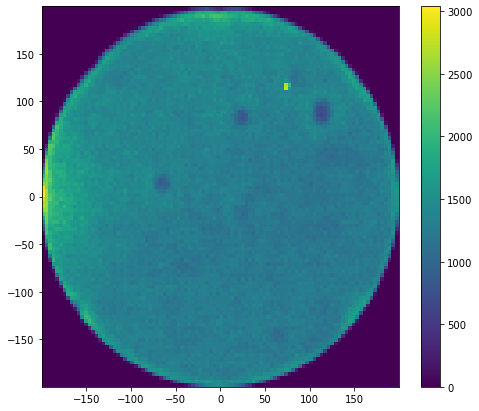

In [10]:
plt.figure(figsize=(8, 7))
plt.hist2d(dst.X, dst.Y, 100);
plt.colorbar();

### 1st check: rate before selection

## Event selection

### nS1 selection (2nd check)

In [11]:
#nS1_eff_interval = (config_values.nS1_eff_min, config_values.nS1_eff_max)
#with pd.HDFStore(histo_file_out, "w", complib=str("zlib"), complevel=4) as store_hist:
#    mask_s1 = selection_nS_mask_and_checking(dst        = dst               ,
#                                             column     = type_of_signal.nS1,
#                                             interval   = nS1_eff_interval  ,
#                                             output_f   = store_hist        ,
#                                             input_mask = None              ,
#                                             nbins_hist = 10                ,
#                                             range_hist = (0,10)            ,
#                                             norm       = True              )

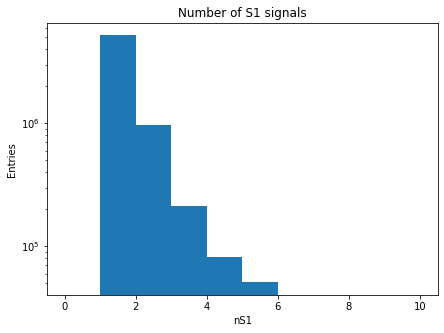

In [12]:
plt.figure(figsize=(7,5));
plt.hist(dst.drop_duplicates(subset='event').nS1, 10, (0, 10))
plt.yscale('log');
plt.xlabel('nS1');
plt.ylabel('Entries');
plt.title('Number of S1 signals');

In [13]:
mask_s1 = dst.nS1==1

In [14]:
eff = dst[mask_s1].event.nunique()/dst.event.nunique()
print('S1 selection efficiency: ', eff*100, '%')

S1 selection efficiency:  79.83140042729502 %


*Some other S1 plots:*

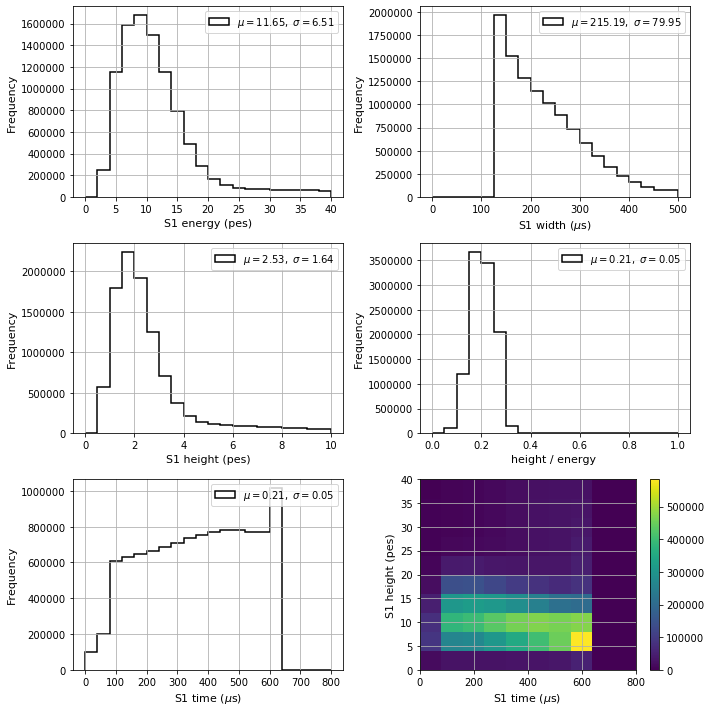

In [15]:
s1d = s1d_from_dst(dst)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

### nS2 selection (3rd chech)

In [16]:
nS2_eff_interval = (config_values.nS2_eff_min, config_values.nS2_eff_max+0.01)
with pd.HDFStore(histo_file_out, "w", complib=str("zlib"), complevel=4) as store_hist:
    mask_s2 = selection_nS_mask_and_checking(dst        = dst               ,
                                             column     = type_of_signal.nS2,
                                             interval   = nS2_eff_interval  ,
                                             output_f   = store_hist        ,
                                             input_mask = mask_s1           ,
                                             nbins_hist = 10                ,
                                             range_hist = (0,10)            ,
                                             norm       = True              )

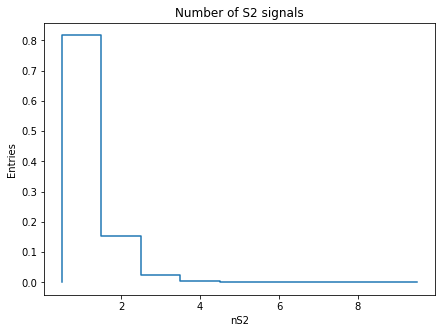

In [17]:
s2_hist = pd.read_hdf(histo_file_out, key='nS2')
plt.figure(figsize=(7,5));
plt.step(s2_hist.magnitude, s2_hist.entries, where='pre');
plt.xlabel('nS2');
plt.ylabel('Entries');
plt.title('Number of S2 signals');

In [18]:
eff = dst[mask_s2].event.nunique()/dst[mask_s1].event.nunique()
print('S2 selection efficiency: ', eff*100, '%')

S2 selection efficiency:  87.51129319496418 %


In [19]:
eff = dst[mask_s2].event.nunique()/dst.event.nunique()
print('Overall selection efficiency: ', eff*100, '%')

Overall selection efficiency:  69.86149088957603 %


*Some other S2 plots:*

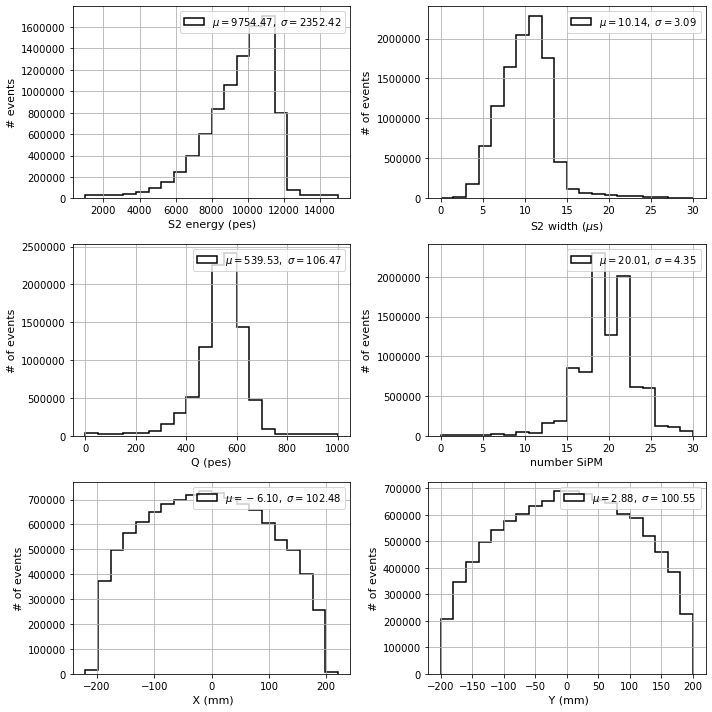

In [20]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### 4th check: Z distribution of events is correct

In [21]:
check_Z_dst(Z_vect   = dst[mask_s2].Z            ,
            ref_hist = ref_histos.Z_dist_hist    ,
            n_sigmas = config_values.nsigmas_Zdst)

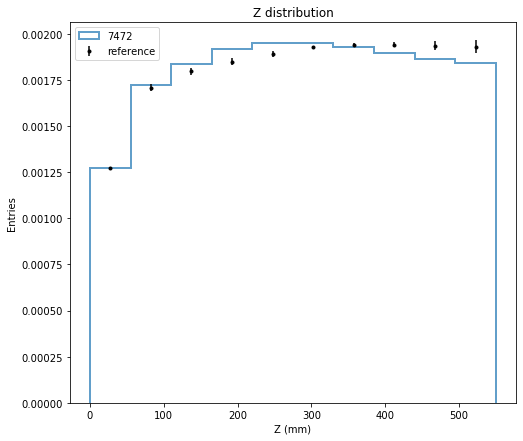

In [22]:
plt.figure(figsize=(8,7));
plt.title('Z distribution');
plt.hist(dst[mask_s2].Z, 10, (0, 550), density=1, histtype='step', alpha=0.7, linewidth=2, label=[run_number]);
plt.errorbar(ref_histos.Z_dist_hist.bin_centres, ref_histos.Z_dist_hist.bin_entries, yerr=ref_histos.Z_dist_hist.err_bin_entries, fmt='.k', label='reference');
plt.legend();
plt.ylabel('Entries');
plt.xlabel('Z (mm)');

*And XY distribution:*

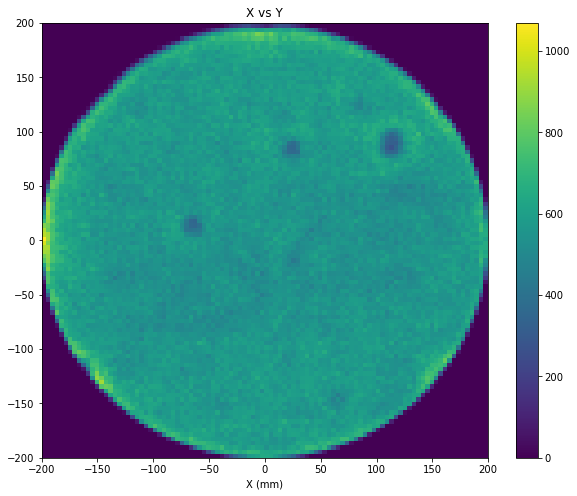

In [23]:
plt.figure(figsize=(10,8))
plt.hist2d(dst[mask_s2].X, dst[mask_s2].Y, 100, [(-200,200),(-200,200)])
plt.xlabel('X (mm)');
plt.xlabel('X (mm)');
plt.title('X vs Y');
plt.colorbar();

### Time stamps

### Band selection (5th check)

*Geom. correction with bootstrap map is applied before*:

In [24]:
# draw_xy_maps(bootstrapmap)

*Applying geometrical correction:*

In [25]:
# dst[mask_s2]

In [26]:
# geom_corr = e0_xy_correction(bootstrapmap)
# corr = geom_corr(dst[mask_s2].X, dst[mask_s2].Y)

In [27]:
# fig = plt.figure(figsize=(14,8))
# plt.subplot(3, 1, 1)
# plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e, 50, range=[[0,510],[5000, 16000]]);

# plt.title('S2e uncorrected')
# plt.subplot(3, 1, 2)
# plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e*corr, 50, range=[[0,510],[11000, 14000]])
# plt.title('S2e corrected boot map')

# plt.subplot(3, 1, 3)
# plt.hist2d(dst[mask_s2].Z, dst[mask_s2].S2e*corr, 50, range=[[0,510],[11000, 14000]])
# plt.title('S2e corrected boot map zoom')
# plt.tight_layout()

In [28]:
dst

event          time  s1_peak  s2_peak  nS1  nS2    S1w       S1h  \
0               2  1.566671e+09        0        0    1    1  125.0  2.186605   
1               6  1.566671e+09        0        0    1    1  200.0  4.730727   
2               7  1.566671e+09        0        0    1    1  175.0  1.734906   
3               8  1.566671e+09        0        0    2    1  125.0  1.170598   
4               8  1.566671e+09        1        0    2    1  125.0  1.680128   
...           ...           ...      ...      ...  ...  ...    ...       ...   
11048522  8382068  1.566758e+09        0        0    1    1  150.0  1.687556   
11048525  8382072  1.566758e+09        0        0    1    1  150.0  1.546145   
11048526  8382074  1.566758e+09        0        0    1    1  175.0  1.070311   
11048527  8382076  1.566758e+09        0        0    2    1  150.0  1.088278   
11048528  8382076  1.566758e+09        1        0    2    1  125.0  1.473445   

                S1e       S1t  ...  Nsipm          DT           Z      Zrms  \
0          8.523943  371850.0  ...     15  281.636383  281.636383  1.685605   
1         20.437023  158300.0  ...     22  496.182098  496.182098  2.219992   
2          8.132517   71175.0  ...     22  583.307861  583.307861  2.554650   
3          3.870362  462125.0  ...     19  190.365387  190.365387  1.406699   
4          5.741284  462375.0  ...     19  190.115387  190.115387  1.406699   
...             ...       ...  ...    ...         ...         ...       ...   
11048522   7.047569  496400.0  ...     17  156.110077  156.110077  1.317946   
11048525   6.188421  166425.0  ...     26  487.061462  487.061462  2.224708   
11048526   6.556684  456600.0  ...     19  195.901642  195.901642  1.412608   
11048527   4.492388  502575.0  ...     18  149.925323  149.925323  1.391081   
11048528   5.919430  502875.0  ...     18  149.625320  149.625320  1.391081   

                   X           Y           R       Phi       Xrms       Yrms  
0          27.186194   78.188736   82.780237  1.236172   9.090803   9.074357  
1        -104.030784  141.503427  175.629223  2.204746  11.154368   9.870412  
2        -168.006980   14.345253  168.618302  3.056414  10.378937  11.877427  
3         -12.824330 -168.425637  168.913169 -1.646792   8.978978   8.389582  
4         -12.824330 -168.425637  168.913169 -1.646792   8.978978   8.389582  
...              ...         ...         ...       ...        ...        ...  
11048522  103.840198   92.237822  138.890613  0.726295   8.169522   8.688181  
11048525   12.643955  161.811077  162.304326  1.492815  28.399776  24.838898  
11048526  -97.823409  139.102557  170.055699  2.183698  10.262700   8.842755  
11048527   38.659612 -185.236861  189.228064 -1.365046   8.106334   8.949124  
11048528   38.659612 -185.236861  189.228064 -1.365046   8.106334   8.949124  

[10618668 rows x 25 columns]

In [29]:
zs1s = exp_dt(dst.Zrms)
zrmss = dst.Z
dZ = zrmss - zs1s

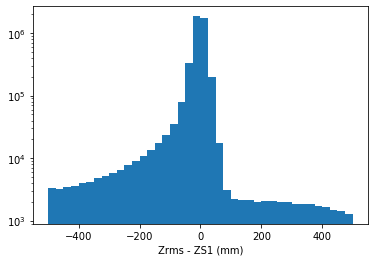

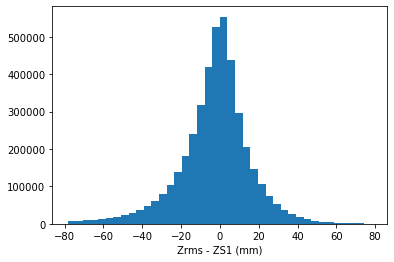

In [30]:
plt.hist(dZ[mask_s2], range = (-500, 500), bins = 40)
plt.xlabel('Zrms - ZS1 (mm)')
plt.yscale('log')
plt.show()

maxdz = np.abs(np.percentile(dZ[mask_s2], 5))
plt.hist(dZ[mask_s2], range = (-maxdz, maxdz), bins = 40)
plt.xlabel('Zrms - ZS1 (mm)')
plt.show()

In [31]:
print('Max dz =', maxdz)

Max dz = 78.37669906608267


In [32]:
mask_band = (np.abs(dZ) < maxdz) & mask_s2

In [33]:
sum(mask_band) / sum(mask_s2)

0.9406843285349904

In [34]:
sel_dst_zs1 = dst[mask_band]
sel_dst_zrms = dst[mask_s2]

## Split into two dsts for map making and resolution checking,
## and separate dsts for Zrms vs ZS1

In [35]:
zrms_mapset = (sel_dst_zrms.event % 2 == 0)
zrms_resset = (sel_dst_zrms.event % 2 == 1)

zs1_mapset = (sel_dst_zs1.event % 2 == 0)
zs1_resset = (sel_dst_zs1.event % 2 == 1)

In [36]:
sel_dst_zrms.Z = exp_dt(sel_dst_zrms.Zrms)

### Increase in spread of Zrms as a function of ZS1

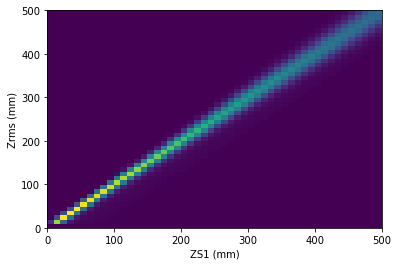

In [37]:
zs1s_bad, zrmss_bad = zs1s, zrmss
zs1s, zrmss = zs1s[mask_band], zrmss[mask_band]

h = plt.hist2d(zs1s, zrmss, range=((0,500),(0,500)), bins = 50)
plt.xlabel('ZS1 (mm)')
plt.ylabel('Zrms (mm)')
plt.show()

In [38]:
binedges = np.linspace(10, 500, 50)
zs1bins = np.array([binedges[:-1], binedges[1:]]).T
zs1bin_centers = 0.5 * (binedges[:-1] + binedges[1:])

In [39]:
def FWHM(X,Y):
    half_max = max(Y) / 2.
    d = np.sign(half_max - np.array(Y[0:-1])) - np.sign(half_max - np.array(Y[1:]))
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    return (X[right_idx] - X[left_idx])[0]

[70. 80.]
74.44609451293945
Mean, std, sigma = 73.04044853035718 10.296667277815926 7.335410766601562


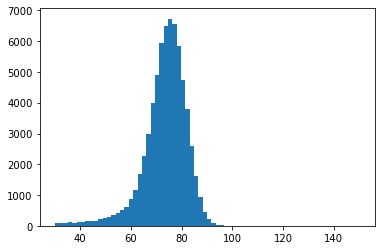

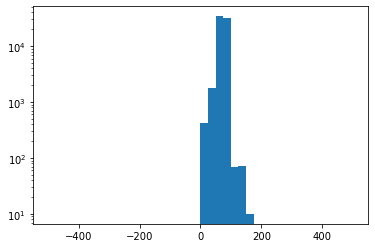

FWHM = 15.428571428571416
Percentile 0 = 11.484000205993652
Percentile 10 = 62.942454147338864
Percentile 20 = 67.84149169921875
Percentile 30 = 70.57706451416016
Percentile 40 = 72.60982971191406
Percentile 50 = 74.44609451293945
Percentile 60 = 76.18925476074219
Percentile 70 = 77.98007049560547
Percentile 80 = 80.0352783203125
Percentile 90 = 82.76333084106446


In [40]:
mybin = zs1bins[6]
print(mybin)
binzrms = zrmss[(zs1s >= mybin[0]) & (zs1s < mybin[1])]
mean, std, sigma = np.mean(binzrms), np.std(binzrms), 0.5*(np.percentile(binzrms, 50+68/2) - np.percentile(binzrms, 50-68/2))


#fwhm = FWHM()
print(np.median(binzrms))
print('Mean, std, sigma =', mean, std, sigma)

h = plt.hist(binzrms, range = (30, 150), bins = 70)
plt.show()

plt.hist(binzrms, range = (-500, 500), bins = 40)
plt.yscale('log')
plt.show()

hbinmids = (h[1][1:] + h[1][:-1])/2
fwhm = FWHM(hbinmids, h[0])
print('FWHM =', fwhm)

for x in range(0, 100, 10):
    print('Percentile', x, '=', np.percentile(binzrms, x))

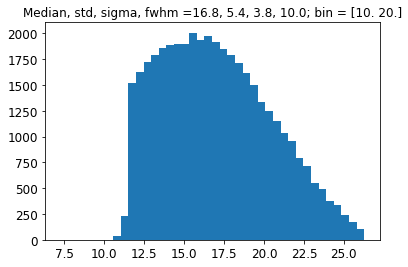

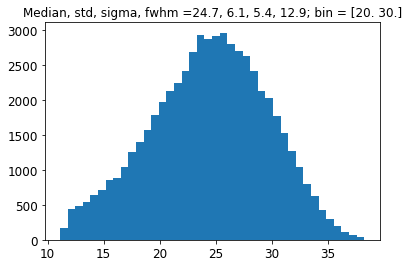

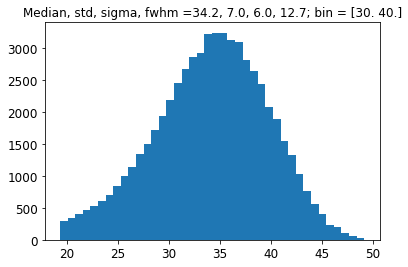

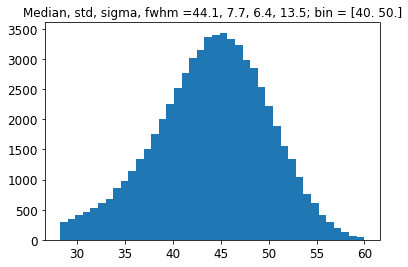

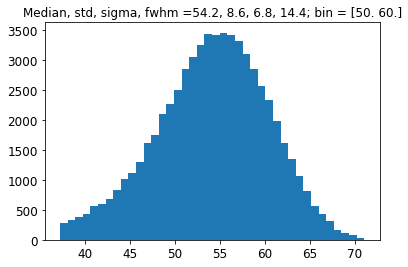

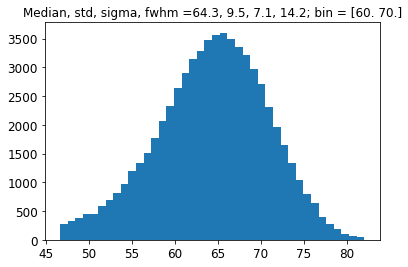

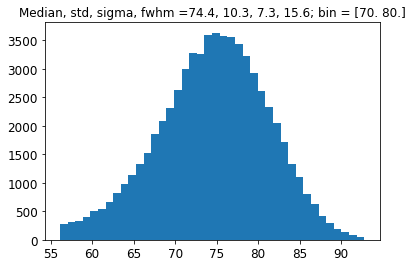

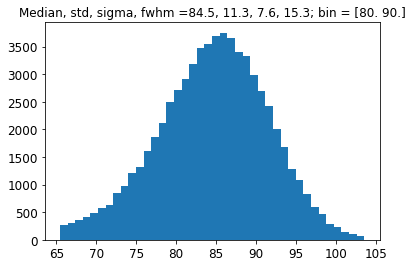

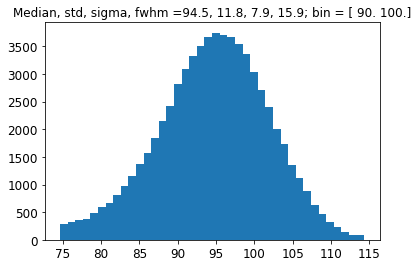

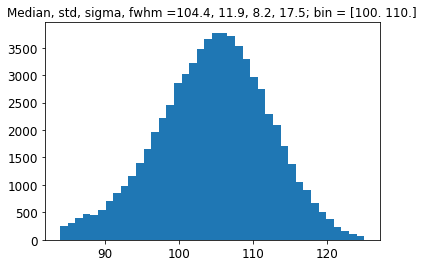

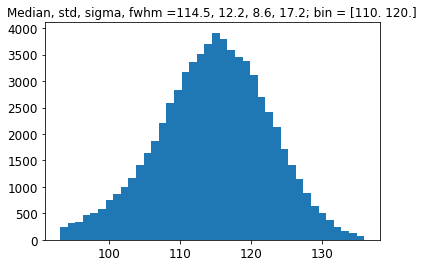

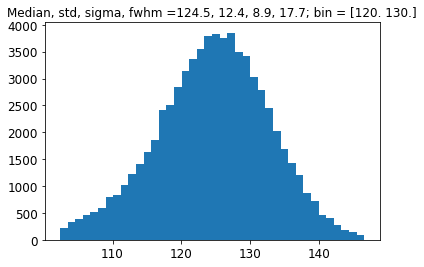

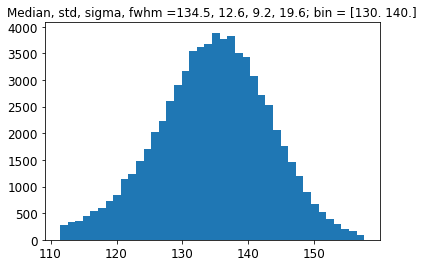

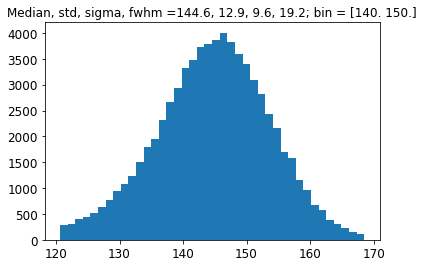

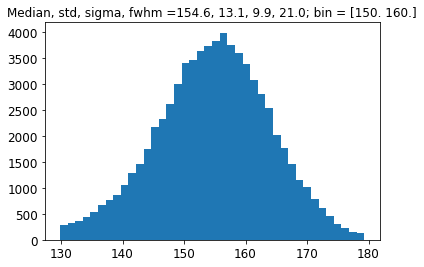

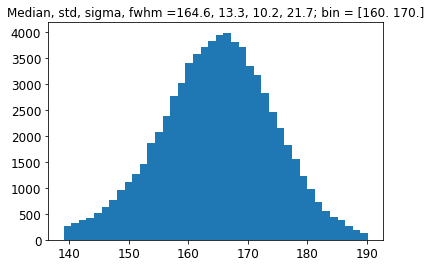

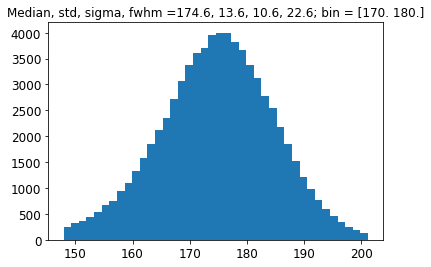

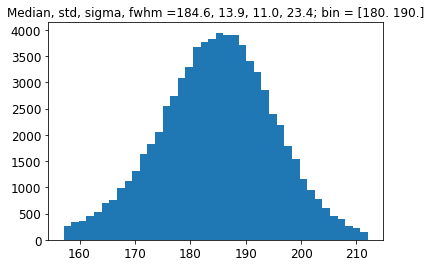

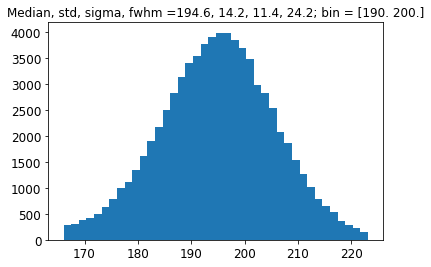

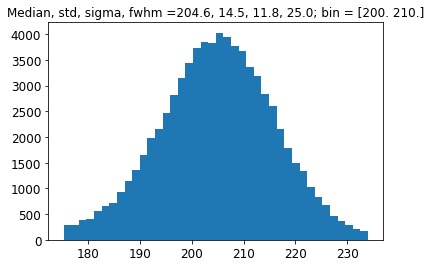

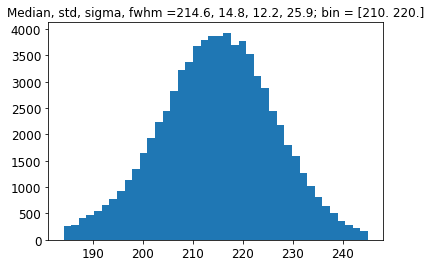

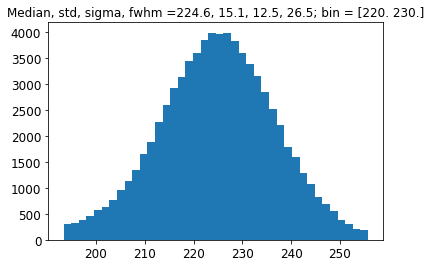

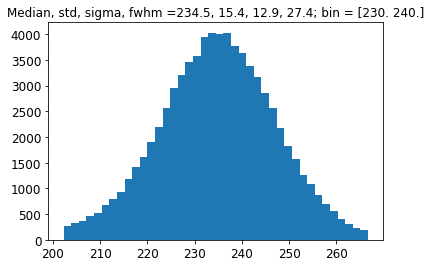

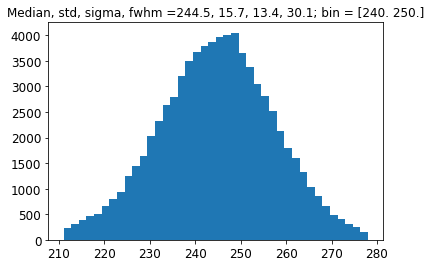

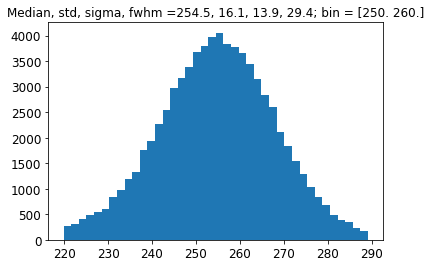

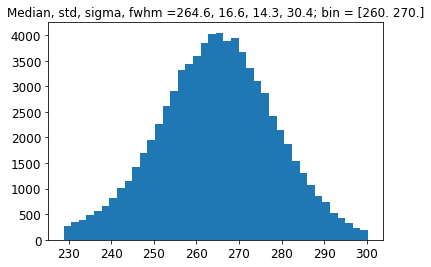

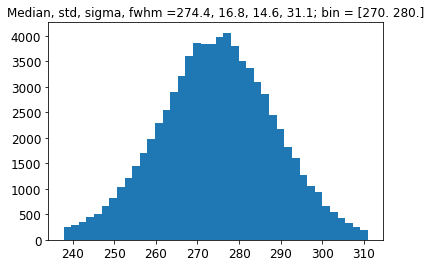

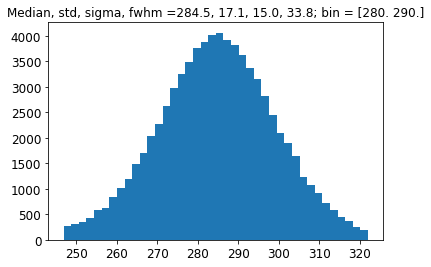

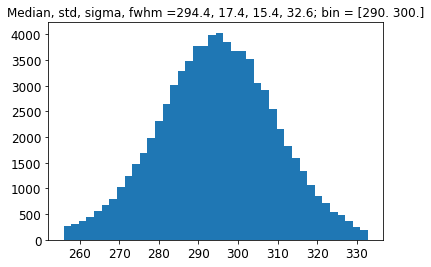

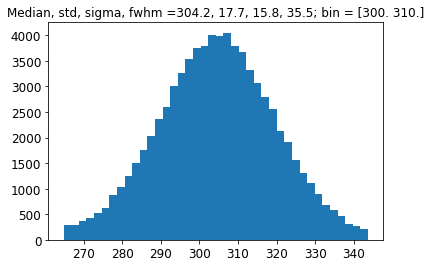

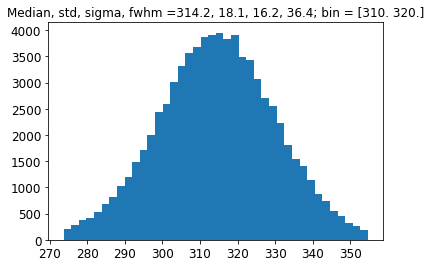

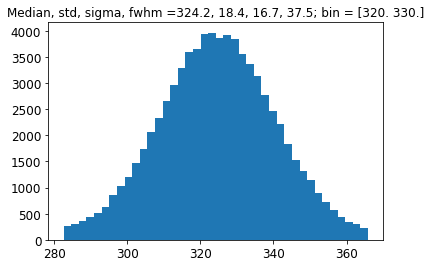

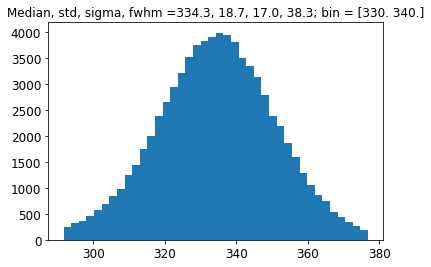

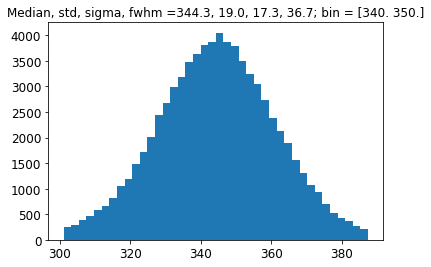

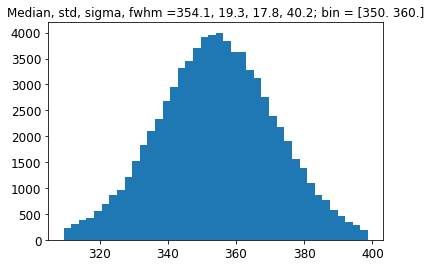

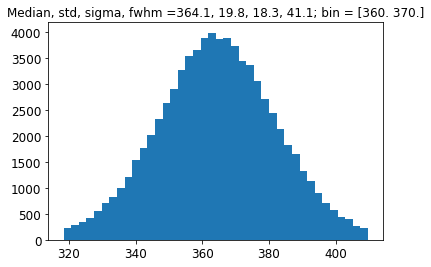

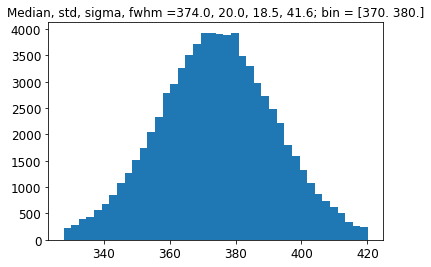

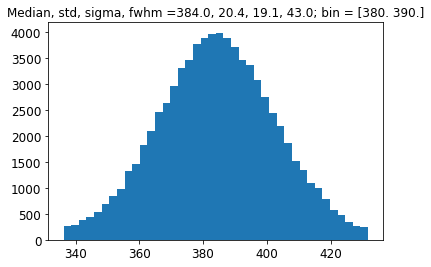

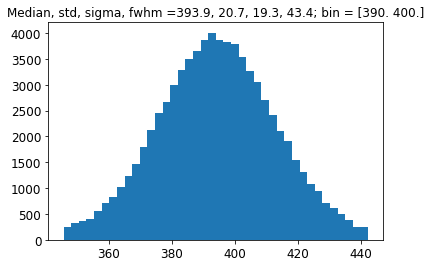

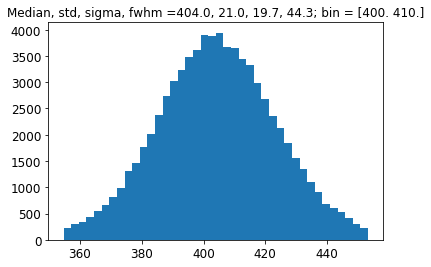

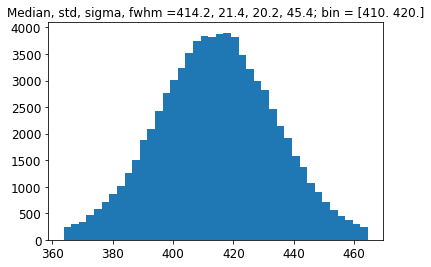

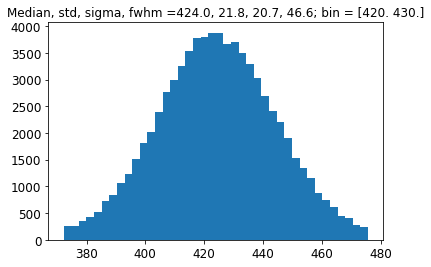

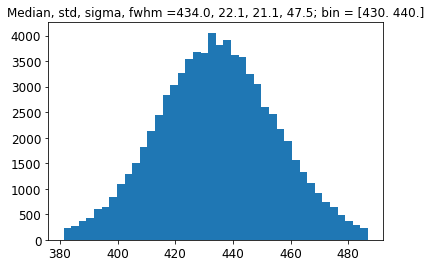

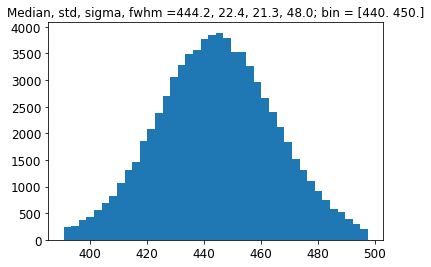

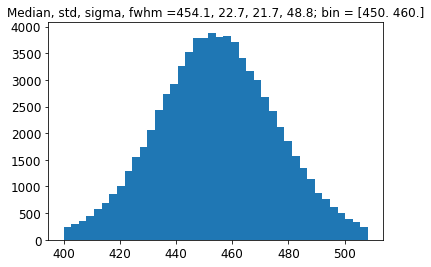

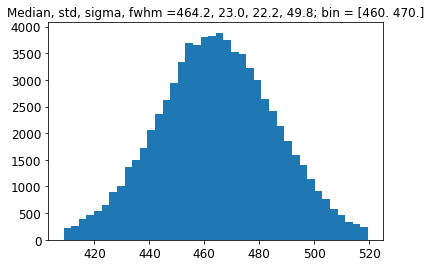

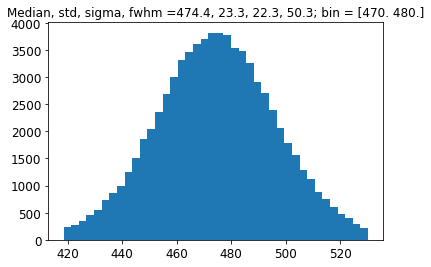

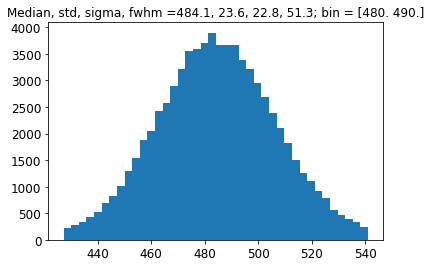

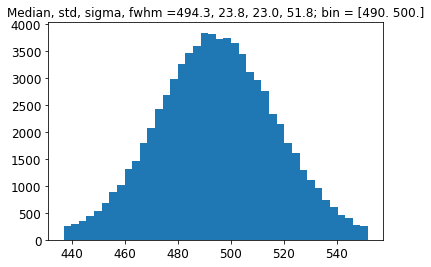

In [41]:
median_zrms = []
std_zrms = []
sigma_zrms = []
fwhm_zrms = []

TEXTSIZE = 12
plt.rc('font', size=TEXTSIZE)
plt.rc('axes', titlesize=TEXTSIZE)
plt.rc('axes', labelsize=TEXTSIZE)
plt.rc('xtick', labelsize=TEXTSIZE)
plt.rc('ytick', labelsize=TEXTSIZE)
plt.rc('legend', fontsize=TEXTSIZE)
plt.rc('figure', titlesize=TEXTSIZE)

for mybin, i in zip(zs1bins, range(len(zs1bins))):
    binzrms = zrmss[(zs1s >= mybin[0]) & (zs1s < mybin[1])]
    median, std, sigma = np.median(binzrms), np.std(binzrms), 0.5*(np.percentile(binzrms, 50+68/2) - np.percentile(binzrms, 50-68/2))
    
    h = plt.hist(binzrms, range=(median-2.5*sigma, median+2.5*sigma), bins = 40)
    hbinmids = (h[1][1:] + h[1][:-1])/2
    fwhm = FWHM(hbinmids, h[0])

    plt.title('Median, std, sigma, fwhm ='+str(round(median,1))+', '+str(round(std,1))+', '+str(round(sigma,1))+', '+str(round(fwhm,1))+'; bin = '+str(mybin))
    plt.show()
    median_zrms.append(median)
    std_zrms.append(std)
    sigma_zrms.append(sigma)
    fwhm_zrms.append(fwhm)

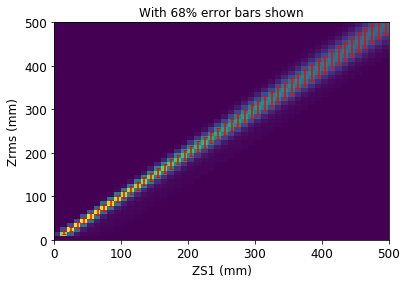

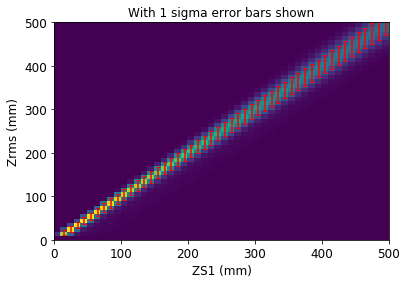

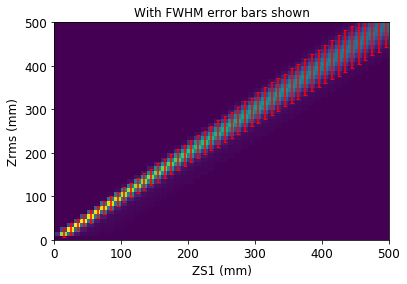

In [64]:
h = plt.hist2d(zs1s, zrmss, range=((0,500),(0,500)), bins = 50)
plt.errorbar(zs1bin_centers, median_zrms, yerr = sigma_zrms, fmt=' ', color='red', capsize = 2)
plt.title('With 68% error bars shown')
plt.xlabel('ZS1 (mm)')
plt.ylabel('Zrms (mm)')
plt.xlim(0,500)
plt.ylim(0,500)
plt.show()

h = plt.hist2d(zs1s, zrmss, range=((0,500),(0,500)), bins = 50)
plt.errorbar(zs1bin_centers, median_zrms, yerr = std_zrms, fmt=' ', color='red', capsize = 2)
plt.title('With 1 sigma error bars shown')
plt.xlabel('ZS1 (mm)')
plt.ylabel('Zrms (mm)')
plt.xlim(0,500)
plt.ylim(0,500)
plt.show()

h = plt.hist2d(zs1s, zrmss, range=((0,500),(0,500)), bins = 50)
plt.errorbar(zs1bin_centers, median_zrms, yerr = fwhm_zrms, fmt=' ', color='red', capsize = 2)
plt.title('With FWHM error bars shown')
plt.xlabel('ZS1 (mm)')
plt.ylabel('Zrms (mm)')
plt.xlim(0,500)
plt.ylim(0,500)
plt.show()

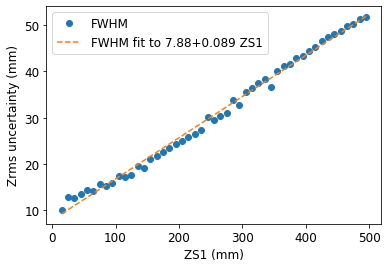

In [62]:
from scipy.optimize import curve_fit

def line(x, a, b):
    return a + b*x

set_text_size(12)

#plt.plot(zs1bin_centers, sigma_zrms, 'o', label='68% radius')
#plt.plot(zs1bin_centers, std_zrms, 'o', label='St. Dev.')
plt.plot(zs1bin_centers, fwhm_zrms, 'o', label='FWHM')

plt.xlabel('ZS1 (mm)')
plt.ylabel('Zrms uncertainty (mm)')

#popt, pcov = curve_fit(line, zs1bin_centers, sigma_zrms)
#fita, fitb = str(round(popt[0], 2)), str(round(popt[1], 3))
#plt.plot(zs1bin_centers, line(zs1bin_centers, *popt), '--', label='68% to '+fita+'+'+fitb+' ZS1', color = 'red')

popt, pcov = curve_fit(line, zs1bin_centers, fwhm_zrms)
fita, fitb = str(round(popt[0], 2)), str(round(popt[1], 3))
plt.plot(zs1bin_centers, line(zs1bin_centers, *popt), '--', label='FWHM fit to '+fita+'+'+fitb+' ZS1')

plt.legend()
plt.show()

## Set up imports and functions necessary for map production and reading

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
from invisible_cities.reco.corrections       import read_maps
from invisible_cities.reco.corrections       import apply_all_correction
from krcal.NB_utils  .xy_maps_functions      import draw_xy_maps

from krcal.NB_utils.plt_functions             import h1, h2
from krcal.NB_utils.fit_energy_functions      import fit_energy
from krcal.NB_utils.plt_energy_functions      import plot_fit_energy, print_fit_energy
from krcal.NB_utils.plt_energy_functions      import resolution_r_z, plot_resolution_r_z

from krcal.map_builder.map_builder_functions  import e0_xy_correction
from krcal.map_builder.map_builder_functions  import load_data
from krcal.map_builder.map_builder_functions  import apply_cuts
from krcal.map_builder.map_builder_functions  import type_of_signal

In [45]:
from krcal.core. kr_types        import ASectorMap
from typing            import Optional
from matplotlib.colors import Colormap
import seaborn as sns
from typing                 import Tuple

def draw_xy_maps_mod(aMap    : ASectorMap,
                 e0lims   : Optional[Tuple[float, float]] = None,
                 ltlims   : Optional[Tuple[float, float]] = None,
                 eulims   : Optional[Tuple[float, float]] = None,
                 lulims   : Optional[Tuple[float, float]] = None,
                 cmap    :  Optional[Colormap]            = None,
                 figsize : Tuple[float, float]            = (14,10)):
    """
    draws correction maps (e0, lt, e0u, ltu) in bins of xy.
    Parameters
    ----------
    aMap
        A container of maps.
        class ASectorMap:
            chi2  : DataFrame
            e0    : DataFrame
            lt    : DataFrame
            e0u   : DataFrame
            ltu   : DataFrame
    e0lims
        Defines the range of e0 in pes (e.g, (8000,14000)).
    ltlims
        Defines the range of lt in mus (e.g, (3000,5000)).
    eulims
        Defines the range of e0u in pes (or relative).
    lulims
        Defines the range of ltu in mus (or relative).
    cmap
        color map. For example: cmap = matplotlib.cm.viridis (defaults to seaborn)
    figsize
        Range definint the figure size.
    Returns
    -------
    Nothing
        Function produces a plot.
    """
    def vmin_max(lims):
        if lims == None:
            vmin = None
            vmax = None
        else:
            vmin=lims[0]
            vmax=lims[1]
        return vmin, vmax

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(2,2,1)
    vmin, vmax = vmin_max(e0lims)
    sns.heatmap(aMap.e0.fillna(0), vmin=vmin, vmax=vmax, cmap=cmap, square=True)

    ax = fig.add_subplot(2,2,2)
    vmin, vmax = vmin_max(eulims)
    sns.heatmap(aMap.e0u.fillna(0), vmin=vmin, vmax=vmax, cmap=cmap, square=True)

    ax = fig.add_subplot(2,2,3)
    vmin, vmax = vmin_max(ltlims)
    sns.heatmap(aMap.lt.fillna(0), vmin=vmin, vmax=vmax, cmap=cmap, square=True)

    ax = fig.add_subplot(2,2,4)
    vmin, vmax = vmin_max(lulims)
    sns.heatmap(aMap.ltu.fillna(0), vmin=vmin, vmax=vmax, cmap=cmap, square=True)
    plt.tight_layout()

In [46]:
from typing      import Iterable
from pandas      import DataFrame

def plot_resolution_r_z_mod(Ri : Iterable[float],
                        Zi : Iterable[float],
                        FC : DataFrame,
                        FCE : DataFrame,
                        r_range: Tuple[float,float] = (3.5, 4.5),
                        figsize = (14,10)):

    def extrapolate_to_qbb(es : float)->float:
        return np.sqrt(41 / 2458) * es

    def np_extrapolate_to_qbb(es : np.array)->np.array:
        return np.sqrt(41 / 2458) * es

    TEXTSIZE = 20
    plt.rc('font', size=TEXTSIZE)
    plt.rc('axes', titlesize=TEXTSIZE)
    plt.rc('axes', labelsize=TEXTSIZE)
    plt.rc('xtick', labelsize=TEXTSIZE)
    plt.rc('ytick', labelsize=TEXTSIZE)
    plt.rc('legend', fontsize=TEXTSIZE)
    plt.rc('figure', titlesize=TEXTSIZE)


    fig       = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    Zcenters =np.array(list(Zi))
    for i in FC.columns:
        label = f'0 < R < {Ri[i]:2.0f}'

        es = FC[i].values
        eus = FCE[i].values
        qes = extrapolate_to_qbb(es)
        qeus = extrapolate_to_qbb(eus)
        ax.errorbar(Zcenters, es, eus,
                    label = label,
                    fmt='o', markersize=10., elinewidth=10.)
        ax2.errorbar(Zcenters, qes, qeus,
                    label = label,
                    fmt='o', markersize=10., elinewidth=10.)
    plt.grid(True)
    ax.set_ylim(r_range)
    ax2.set_ylim(np_extrapolate_to_qbb(np.array(r_range)))

    ax.set_xlabel(' z (mm)')
    ax.set_ylabel('resolution FWHM (%)')
    ax2.set_ylabel('resolution Qbb FWHM (%)')

    plt.legend()

In [47]:
import invisible_cities.core.fit_functions as fitf

def energy_X_profile(X      : np.array,
                     E      : np.array,
                     xnbins : int,
                     xrange : Tuple[float, float],
                     xlabel : str = 'R',
                     erange : Tuple[float, float] = (9e+3, 14e+3),
                     figsize : Tuple[float, float] = (10,8)):

    TEXTSIZE = 20
    plt.rc('font', size=TEXTSIZE)
    plt.rc('axes', titlesize=TEXTSIZE)
    plt.rc('axes', labelsize=TEXTSIZE)
    plt.rc('xtick', labelsize=TEXTSIZE)
    plt.rc('ytick', labelsize=TEXTSIZE)
    plt.rc('legend', fontsize=TEXTSIZE)
    plt.rc('figure', titlesize=TEXTSIZE)

    fig = plt.figure(figsize=figsize)

    x, y, yu = fitf.profileX(X, E, xnbins, xrange)
    ax = fig.add_subplot(1, 1, 1)

    plt.errorbar(x, y, yu, fmt="kp", ms=7, lw=3)
    plt.xlabel(xlabel)
    plt.ylabel('E (pes)')
    plt.ylim(erange)

## Map production

In [48]:
def produce_and_check_map(map_dst, res_dst, map_tag):

    tag_map_file_out = os.path.join(output_maps_file, 'TEST_kr_emap_xy_r_'+str(run_number)+'_'+analysis_tag+'_'+map_tag+'.h5')

    # Select number of xy bins

    thr_evts_for_sel_map_bins = config_values.thr_evts_for_sel_map_bins
    default_n_bins            = config_values.default_n_bins

    # > 1e6 -> 100^2
    # < 1e6 -> 50^2
    number_of_bins = get_binning_auto(nevt_sel                = map_dst.event.nunique()  ,
                                      thr_events_for_map_bins = thr_evts_for_sel_map_bins,
                                      n_bins                  = default_n_bins           )
    print('Number of XY bins: ', number_of_bins, '(', map_dst.event.nunique(), 'events)')

    # Map computation

    map_params = config_values.map_params
    map_params

    map_params_new = config['map_params']
    map_params_new['nbins_z']   = (15)
    map_params_new['z_range']   = (10, 510)
    map_params_new['e_range']    = (2000, 18000)
    map_params_new['lt_range']   = (5000, 20000)
    map_params_new['chi2_range'] = (0, 10000)
    map_params_new['r_max'] = 200
    map_params_new['x_range'] = (-200, 200)
    map_params_new['y_range'] = (-200, 200)
    map_params_new['maxFailed'] = 2500

    warnings.filterwarnings("ignore")
    logging.disable(logging.DEBUG)
    this_script_logger = logging.getLogger(__name__)
    this_script_logger.setLevel(logging.INFO)

    print('Calculating map...')
    maps = calculate_map(dst        = map_dst                 ,
                         XYbins     = (number_of_bins         ,
                                       number_of_bins)        ,
                         nbins_z    = map_params_new['nbins_z']   ,
                         nbins_e    = map_params_new['nbins_e']   ,
                         z_range    = map_params_new['z_range']   ,
                         e_range    = map_params_new['e_range']   ,
                         chi2_range = map_params_new['chi2_range'],
                         lt_range   = map_params_new['lt_range']  ,
                         fit_type   = FitType.unbined         ,
                         nmin       = map_params_new['nmin']      ,
                         x_range    = map_params_new['x_range']   ,
                         y_range    = map_params_new['y_range']   )
    print('Calculated map. Proceeding to check fits.')
    
    # Check failed fits
    maxFailed = map_params['maxFailed']
    r_max     = map_params['r_max']

    check_failed_fits(maps      = maps          ,
                      maxFailed = maxFailed     ,
                      nbins     = number_of_bins,
                      rmax      = r_max         ,
                      rfid      = r_max         )

    # Chi2 regularization
    regularized_maps = regularize_map(maps    = maps                    ,
                                      x2range = map_params['chi2_range'])

    regularized_maps = relative_errors(am = regularized_maps)

    # Kill outer bins
    regularized_maps = remove_peripheral(map   = regularized_maps,
                                         nbins = number_of_bins  ,
                                         rmax  = r_max           ,
                                         rfid  = r_max           )

    # Print maps
    print('Showing determined maps')
    draw_xy_maps(regularized_maps,
                 figsize=(14,10))

    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.hist(regularized_maps.lt.values.flatten(), 100, (7000, 15000));
    plt.title('lt')
    plt.xlabel('lt (mus)');
    plt.subplot(122)
    plt.hist(regularized_maps.e0.values.flatten(), 100, (7000, 14000));
    plt.title('e0')
    plt.xlabel('e0 (pes)');

    # Add mapinfo
    maps = add_mapinfo(asm        = regularized_maps     ,
                       xr         = map_params['x_range'],
                       yr         = map_params['y_range'],
                       nx         = number_of_bins       ,
                       ny         = number_of_bins       ,
                       run_number = run_number           )
    print(maps.mapinfo)

    # Save map
    write_complete_maps(asm      = maps        ,
                        filename = tag_map_file_out)

    # Try to open and show map

    print('Try to open and show map...')
    try:
        final_map = read_maps(tag_map_file_out)
    except FileNotFoundError:
        print('Please run Section A or B. If you have already done it, the dst is not good enough to produce a map :(')

    draw_xy_maps_mod(final_map,
                 figsize=(14,10))

    print(final_map.mapinfo)

    sel_res_dst = res_dst[res_dst.R<200]

    # Apply corrections to dst
    geom_corr = e0_xy_correction(final_map)
    total_correction = apply_all_correction(final_map, apply_temp=False)

    corr_geo = geom_corr(sel_res_dst.X, sel_res_dst.Y)
    corr_tot = total_correction(sel_res_dst.X, sel_res_dst.Y, sel_res_dst.Z, sel_res_dst.time)

    # Check corrected energy vs Z
    print('Show corrected energy vs Z...')
    
    TEXTSIZE = 12
    plt.rc('font', size=TEXTSIZE)
    plt.rc('axes', titlesize=TEXTSIZE)
    plt.rc('axes', labelsize=TEXTSIZE)
    plt.rc('xtick', labelsize=TEXTSIZE)
    plt.rc('ytick', labelsize=TEXTSIZE)
    plt.rc('legend', fontsize=TEXTSIZE)
    plt.rc('figure', titlesize=TEXTSIZE)

    fig = plt.figure(figsize=(10,10))
    plt.subplot(3, 1, 1)
    plt.hist2d(sel_res_dst.Z, sel_res_dst.S2e, 50, [(0,510),(8000,14000)])
    plt.title('Raw energy');
    plt.subplot(3, 1, 2)
    plt.hist2d(sel_res_dst.Z, sel_res_dst.S2e*corr_geo, 50, [(0,510),(11000,14000)])
    plt.title('Geom. corrected energy');
    plt.subplot(3, 1, 3)
    plt.hist2d(sel_res_dst.Z, sel_res_dst.S2e*corr_tot, 50, [(0,510),(11000,14000)])
    plt.title('Total corrected energy');
    plt.show()

    # Show total corrected Kr peak

    print('Show corrected Kr peak...')
    e_range = (10000,15000)
    zrange = (0,510)
    fig = plt.figure(figsize=(14,8))
    plt.subplot(1, 2, 1)

    nevt = h2(sel_res_dst.Z, sel_res_dst.S2e*corr_tot, 30, 30, zrange, e_range, profile=True)
    plt.xlabel('Z (mm)');
    plt.ylabel('E (pes)');
    plt.title('E vs Z');

    ax      = fig.add_subplot(1, 2, 2)
    (_)     = h1(sel_res_dst.S2e*corr_tot,  bins = 100, range =e_range, stats=True, lbl = 'E')
    plt.xlabel('E (pes)');
    plt.ylabel('Entries');
    plt.title('E corr');

    # Check total energy resolution

    fc = fit_energy(sel_res_dst.S2e*corr_tot, nbins=100, range=(11000, 15000))
    plot_fit_energy(fc)
    print_fit_energy(fc)

    # Show resolution vs ZR

    print('Resolution vs ZR...')
    Ri = (50,100,150, 200)
    Zi = (100, 200, 300, 400, 510)

    FC, FCE = resolution_r_z(Ri, Zi, sel_res_dst.R, sel_res_dst.Z, sel_res_dst.S2e*corr_tot,
                        enbins = 50,
                        erange = (11000,15000),
                        ixy = (5,5),
                        fdraw  = True,
                        fprint = False,
                        figsize = (18,10))

    plt.show()

    plot_resolution_r_z_mod(Ri, Zi, FC, FCE, r_range=(3.5,5.5))
    plt.show()

    plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(3.75,4.25))

    # Show additional plots
    print('Additional plots')

    num_xy_bins = 50
    energy_X_profile(sel_res_dst.R, sel_res_dst.S2e*corr_tot, xnbins = number_of_bins, xrange=(0,200), xlabel = 'R',
                     erange=(9000, 14500),  
                     figsize=(12,6))
    plt.show()

    energy_X_profile(sel_res_dst.Z, sel_res_dst.S2e*corr_tot, xnbins = number_of_bins, xrange=(0, 550), xlabel = 'Z',
                     erange=e_range,   
                     figsize=(12,6))
    plt.show()

Number of XY bins:  100 ( 2135965 events)
Calculating map...
Calculated map. Proceeding to check fits.
    Number of failing fits: 146
Showing determined maps


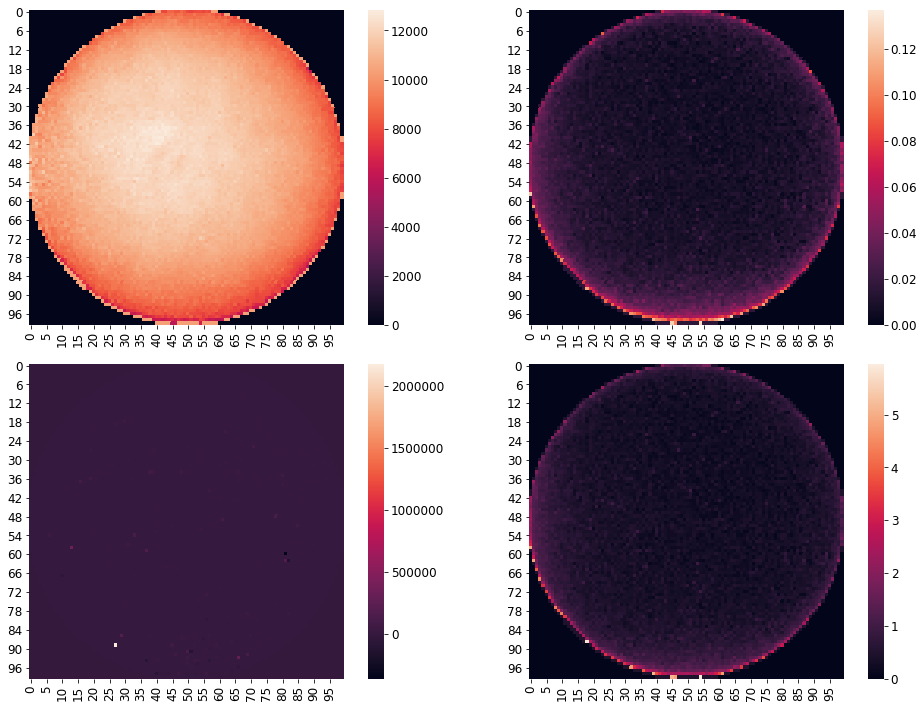

xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7472
dtype: int64
Try to open and show map...
xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7472
dtype: int64
Show corrected energy vs Z...


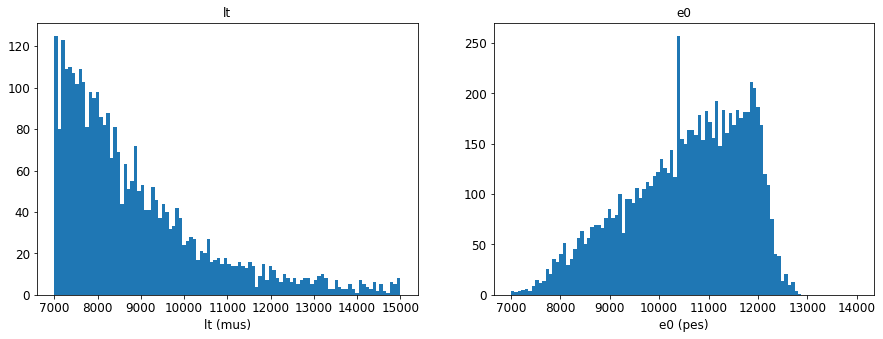

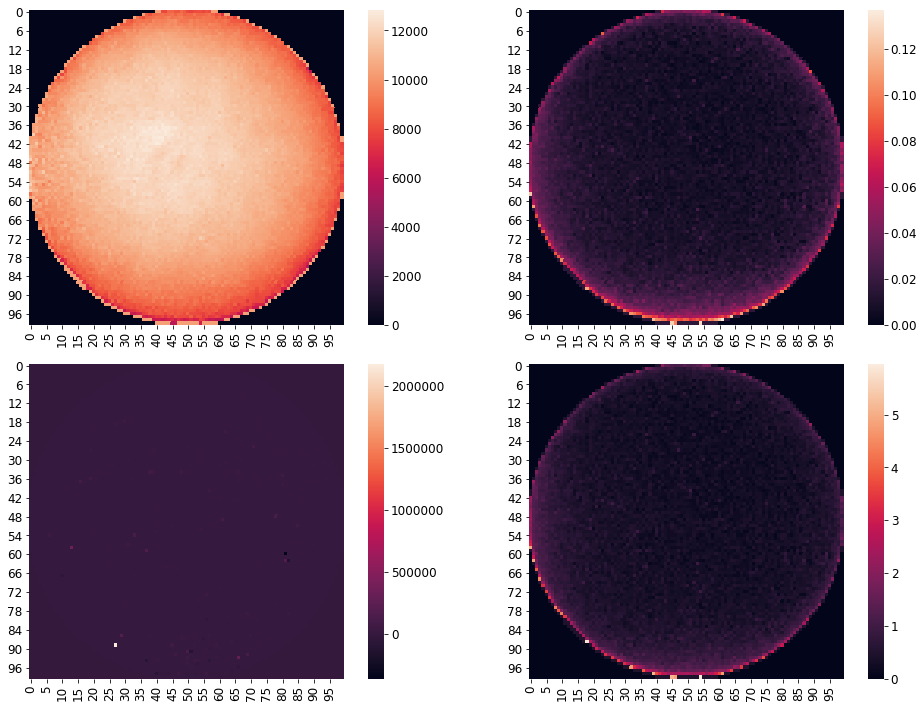

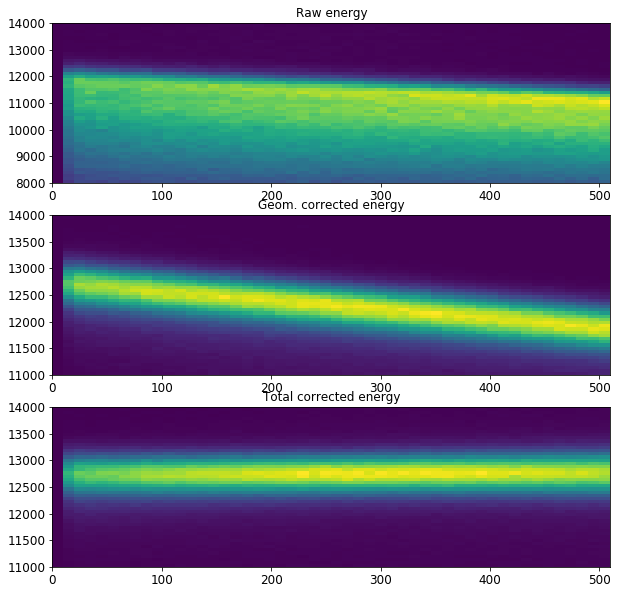

Show corrected Kr peak...
  Fit was valid = True
 Emu       = 12732.179278946658 +-0.20762146139153106 
 E sigma   = 286.0930168175498 +-0.16240583294553043 
 chi2    = 996.220072695036 
 sigma E/E (FWHM)     (%) =5.280467505142321
 sigma E/E (FWHM) Qbb (%) =0.6819827087004513 
Resolution vs ZR...


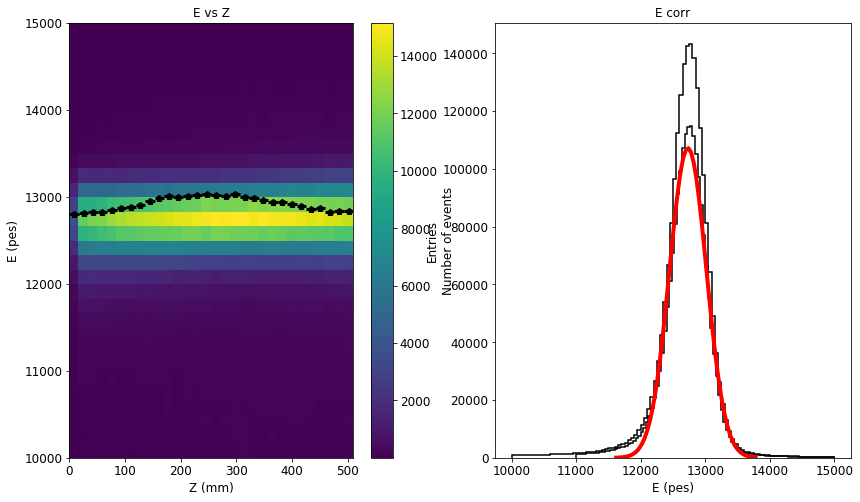

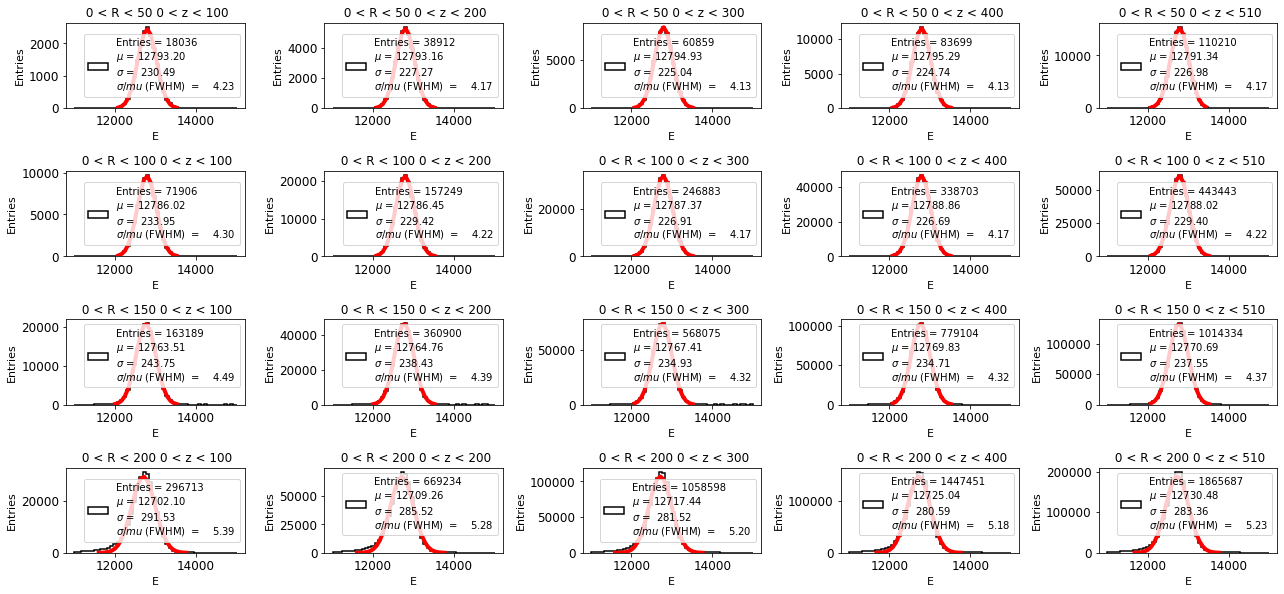

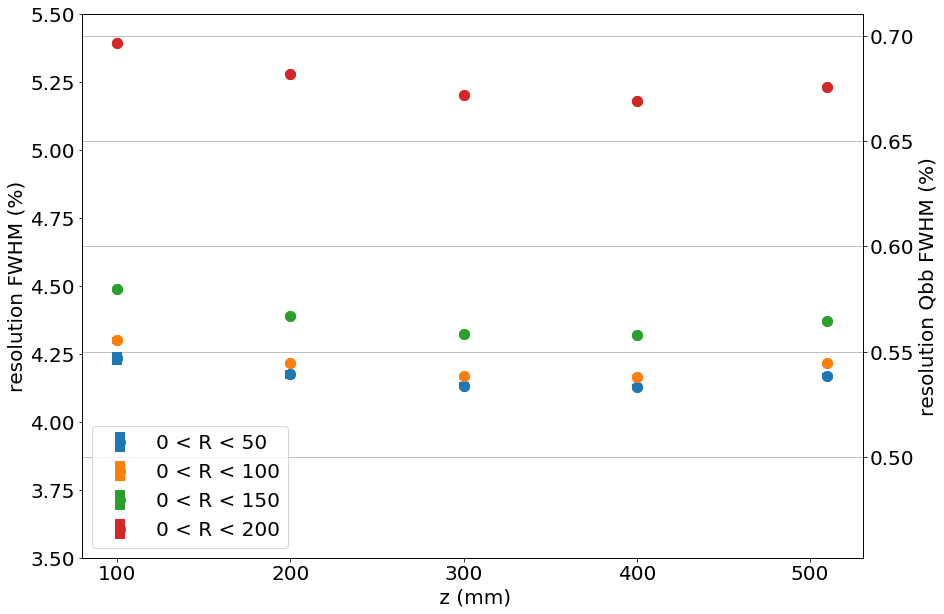

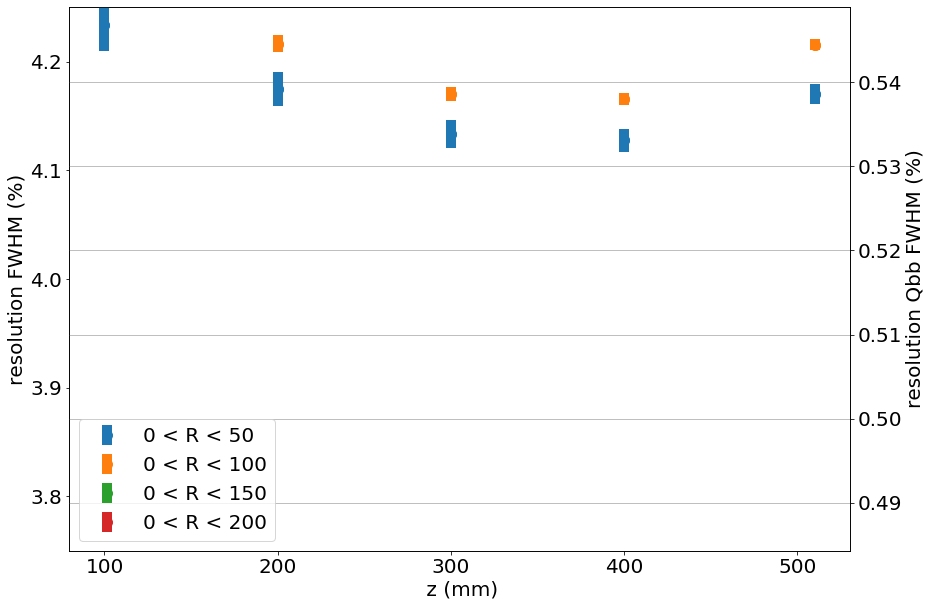

Additional plots


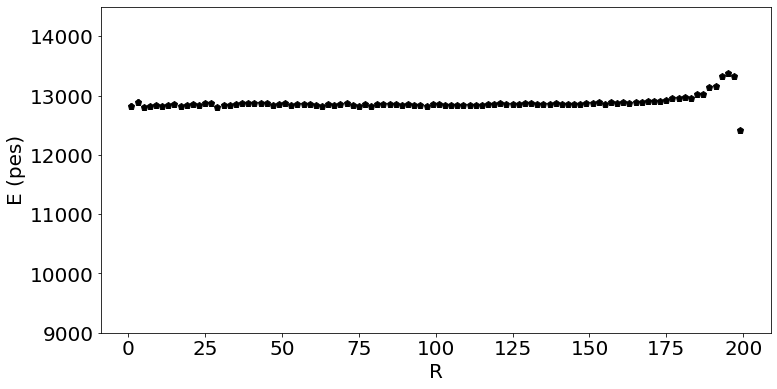

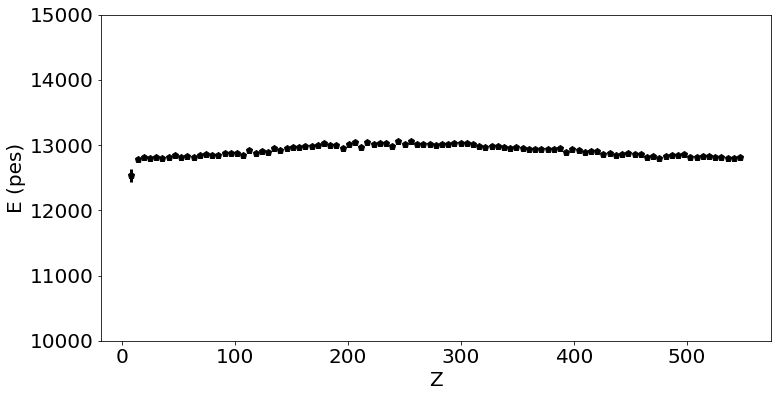

In [49]:
produce_and_check_map(sel_dst_zs1[zs1_mapset], sel_dst_zs1[zs1_resset], 'zs1')

Number of XY bins:  100 ( 2270389 events)
Calculating map...
Calculated map. Proceeding to check fits.
    Number of failing fits: 136
Showing determined maps


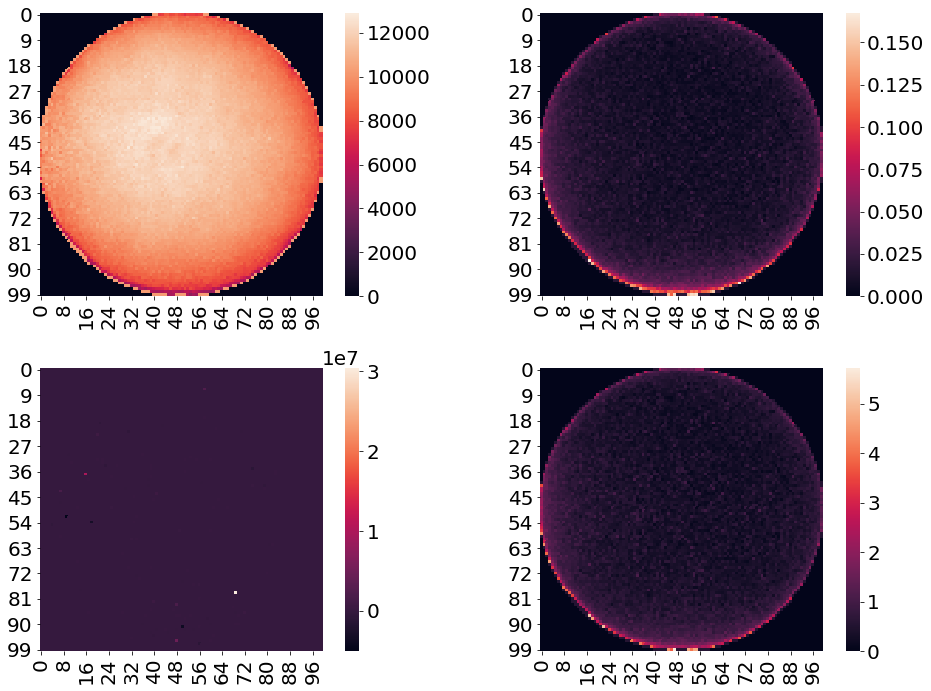

xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7472
dtype: int64
Try to open and show map...
xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7472
dtype: int64
Show corrected energy vs Z...


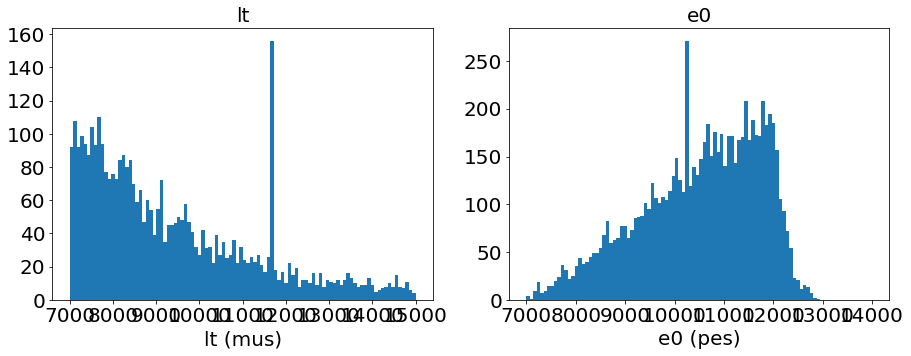

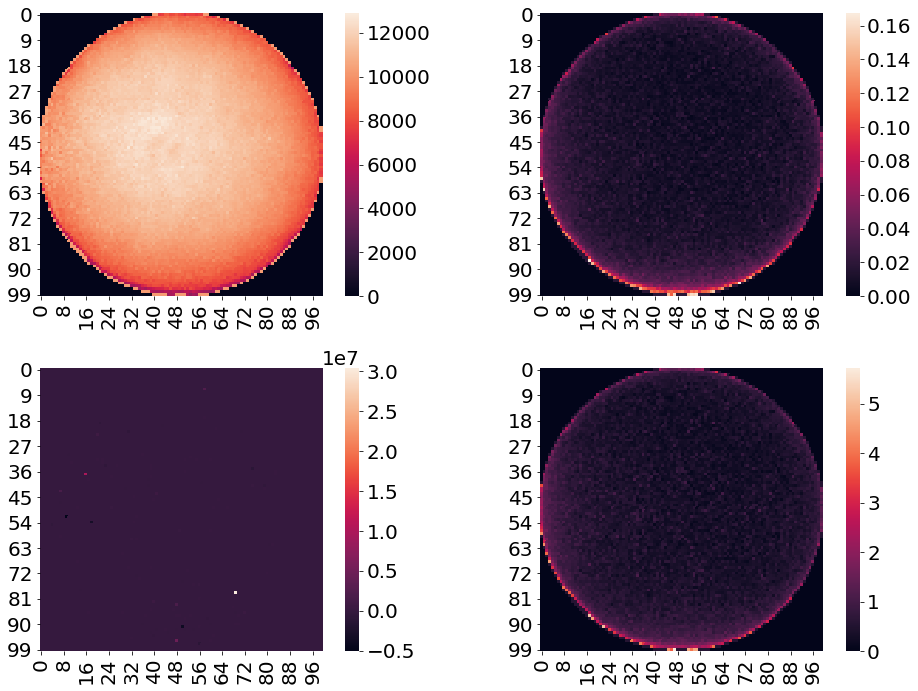

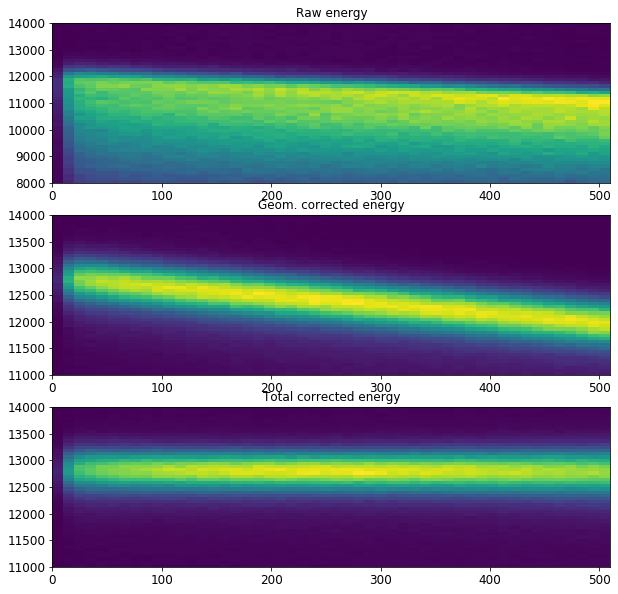

Show corrected Kr peak...
  Fit was valid = True
 Emu       = 12782.530612707147 +-0.21886731123429676 
 E sigma   = 307.2596567305343 +-0.17230055622304913 
 chi2    = 1024.5957528314734 
 sigma E/E (FWHM)     (%) =5.648804725716468
 sigma E/E (FWHM) Qbb (%) =0.7295541813319418 
Resolution vs ZR...


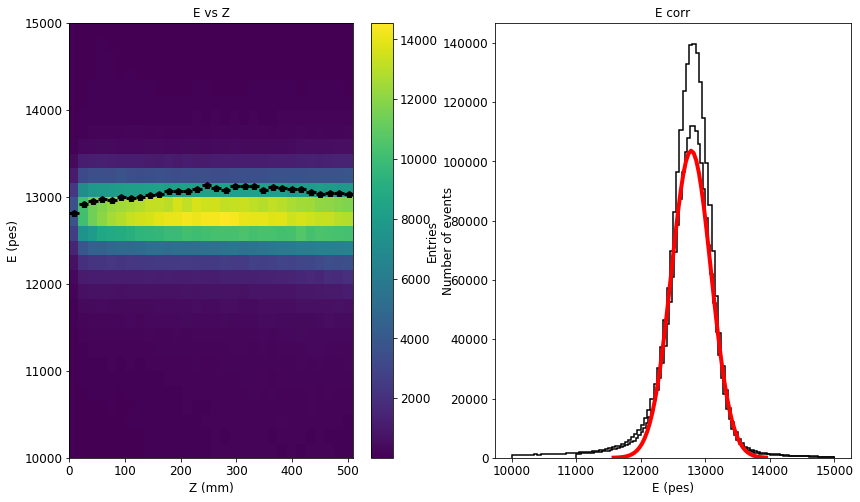

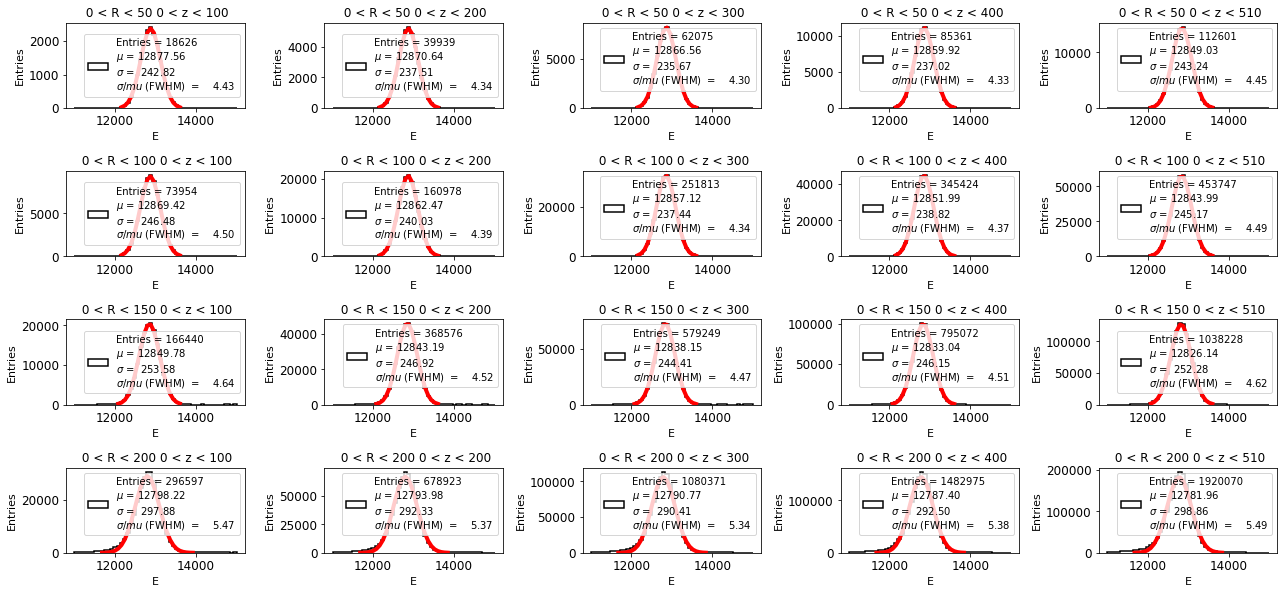

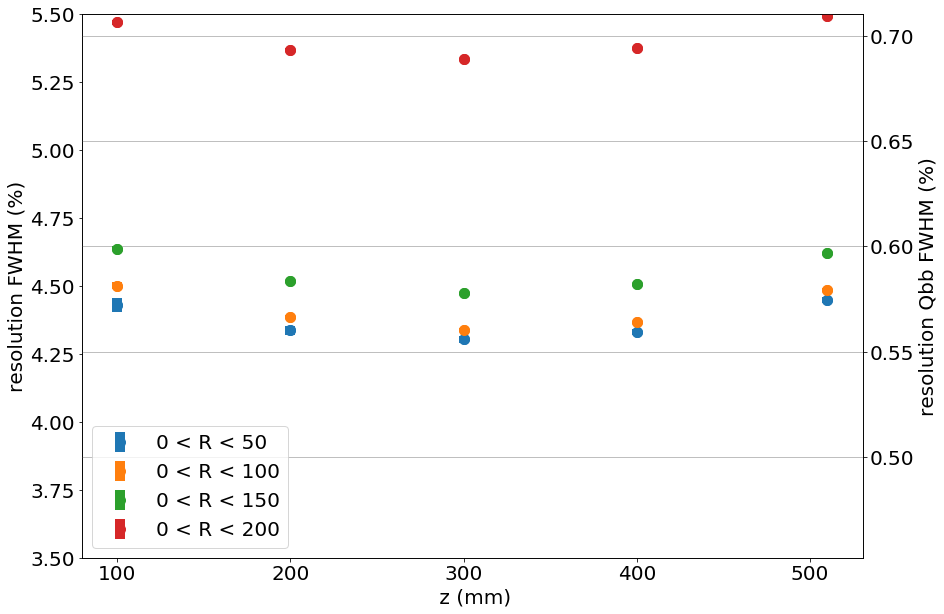

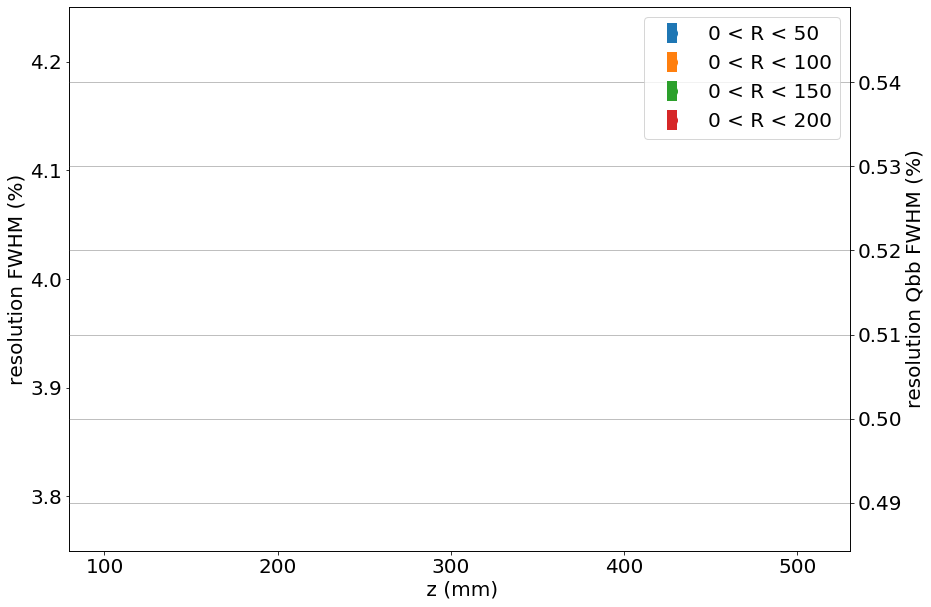

Additional plots


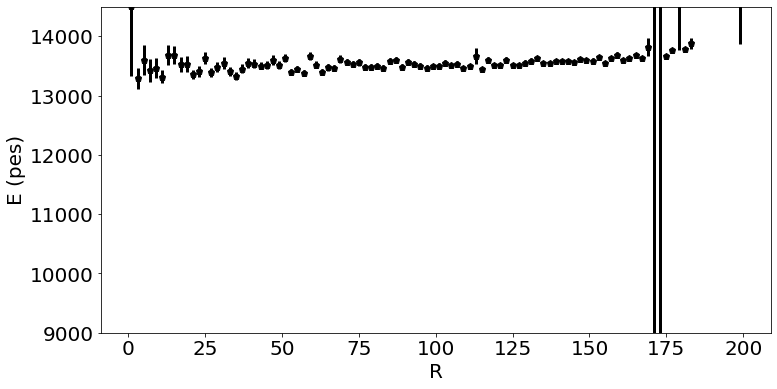

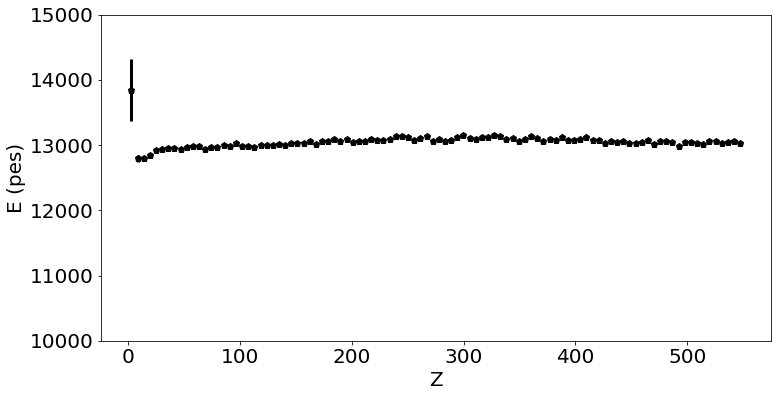

In [50]:
produce_and_check_map(sel_dst_zrms[zrms_mapset], sel_dst_zrms[zrms_resset], 'zrms')

Number of XY bins:  100 ( 4268849 events)
Calculating map...
Calculated map. Proceeding to check fits.
    Number of failing fits: 86
Showing determined maps


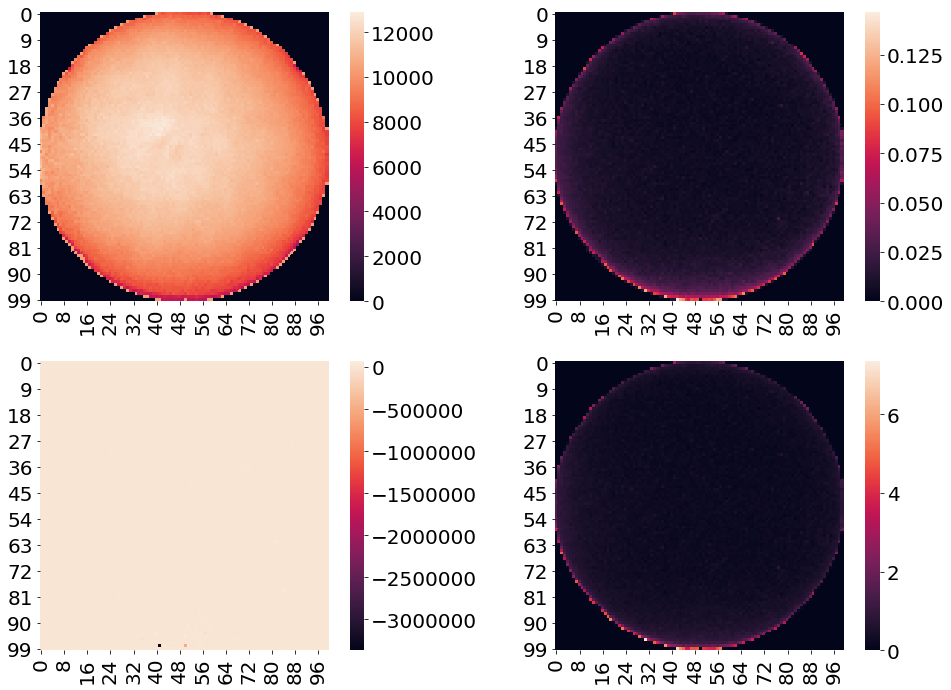

xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7472
dtype: int64
Try to open and show map...
xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7472
dtype: int64
Show corrected energy vs Z...


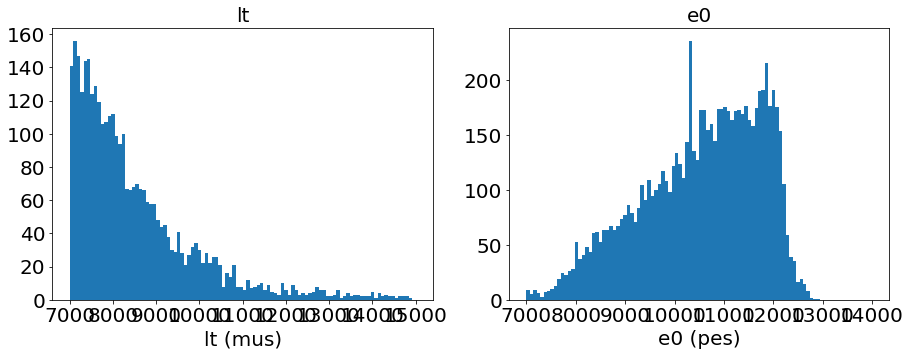

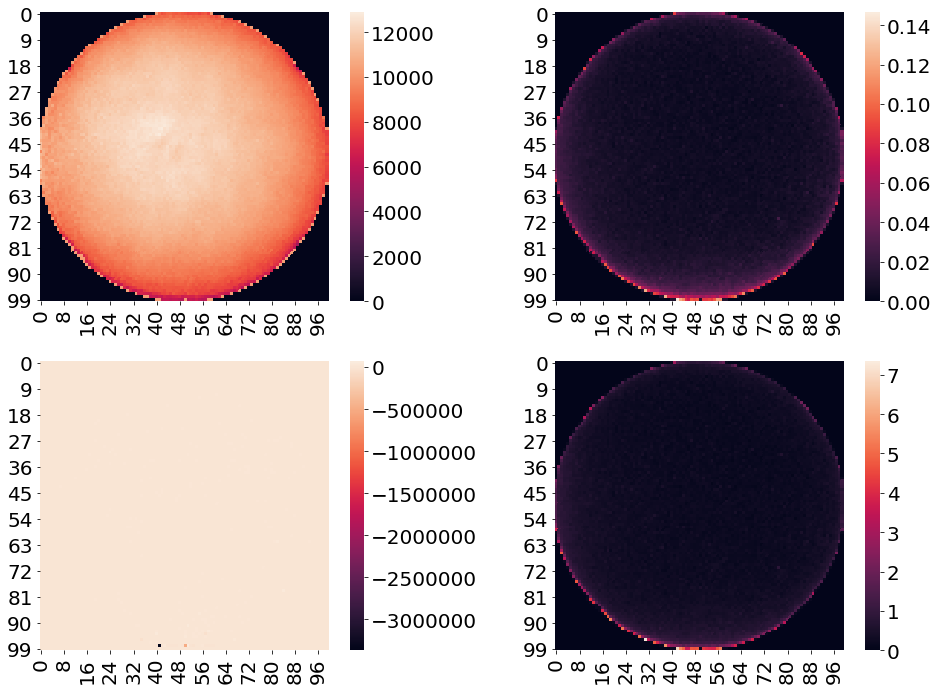

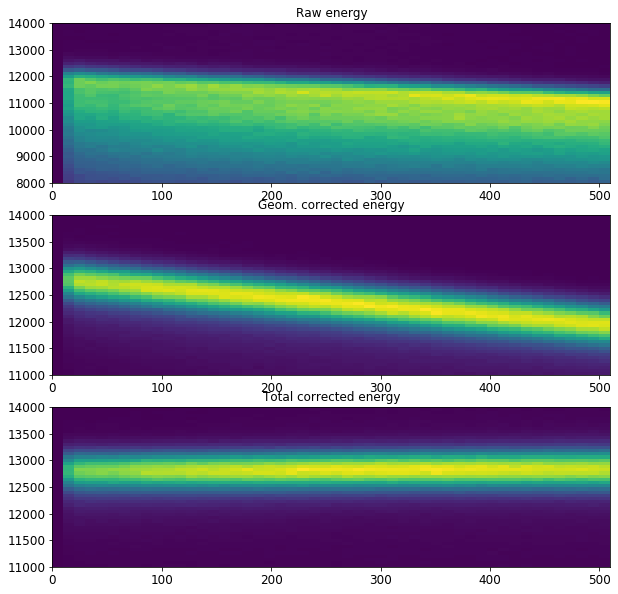

Show corrected Kr peak...
  Fit was valid = True
 Emu       = 12804.978567453769 +-0.1409305005131712 
 E sigma   = 275.0959494976649 +-0.10986071221781624 
 chi2    = 2048.3111005249975 
 sigma E/E (FWHM)     (%) =5.048626031773688
 sigma E/E (FWHM) Qbb (%) =0.6520399288531995 
Resolution vs ZR...


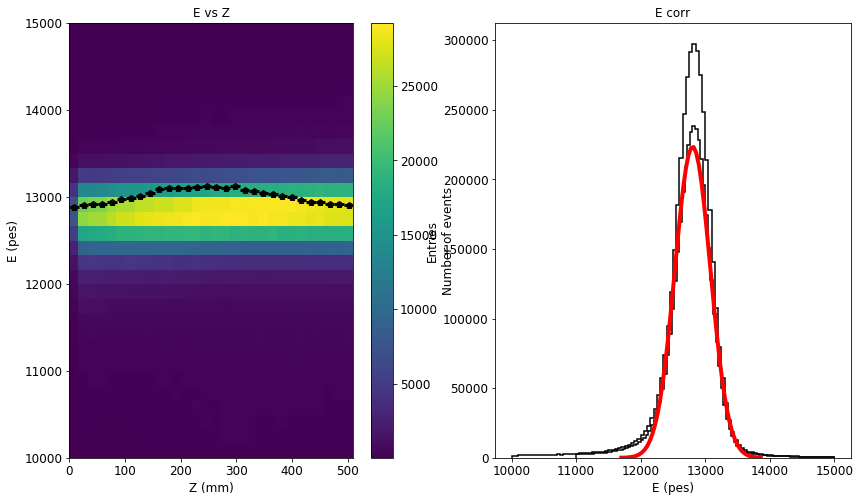

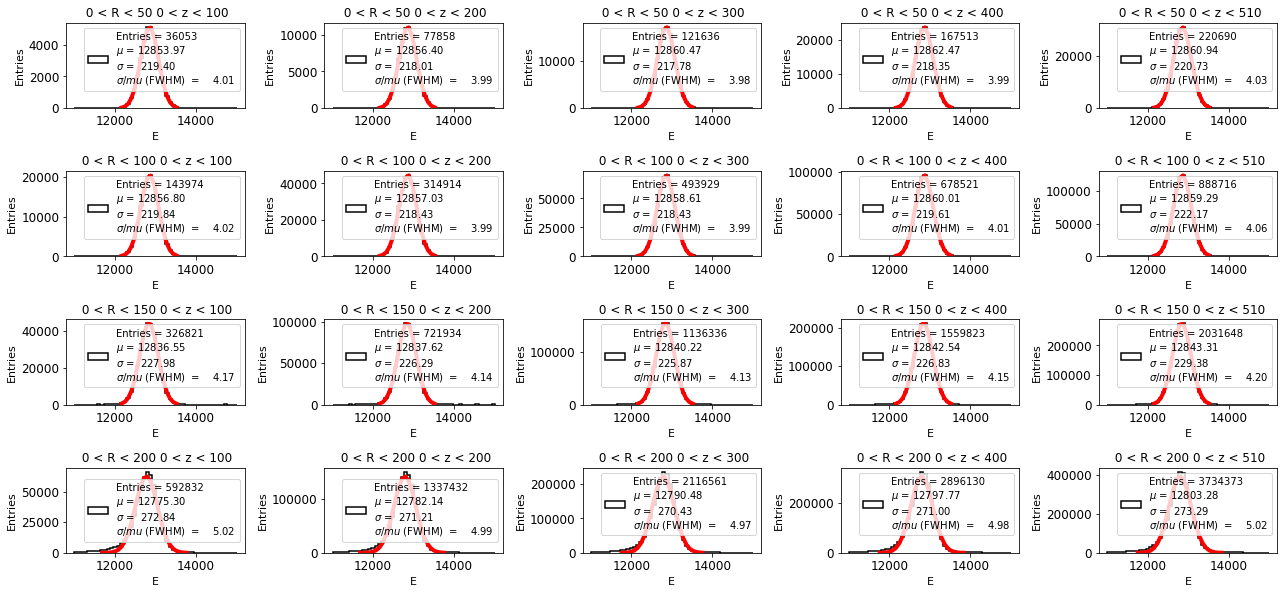

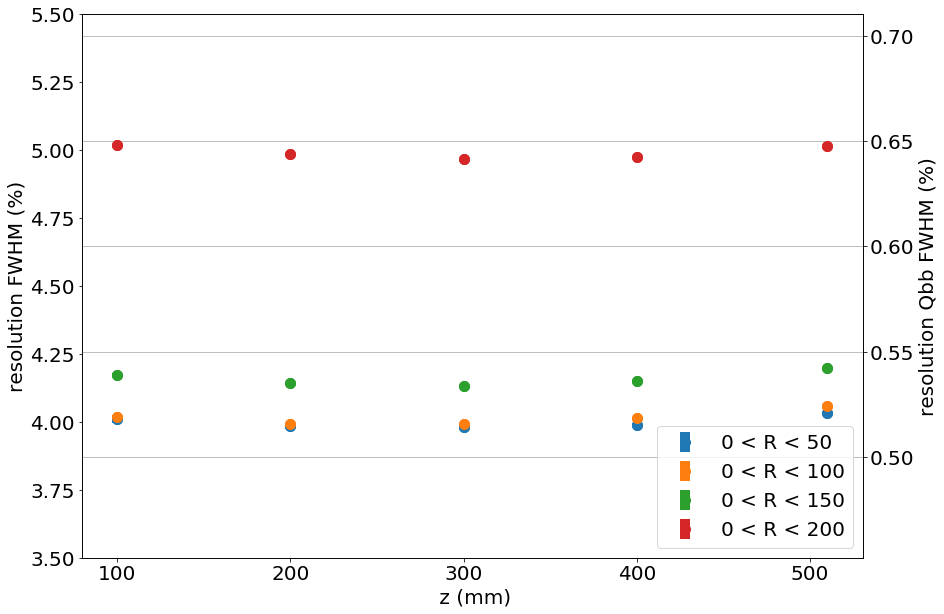

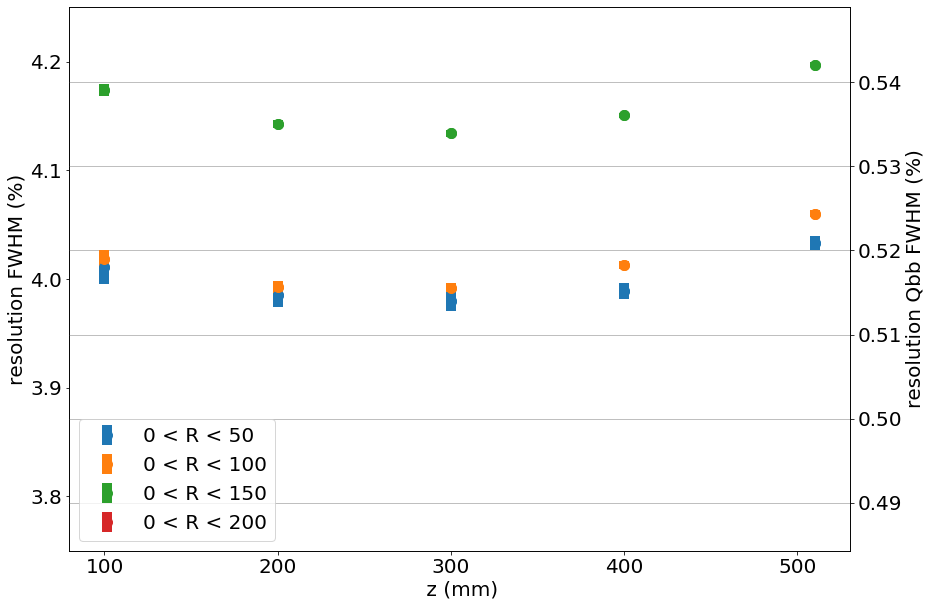

Additional plots


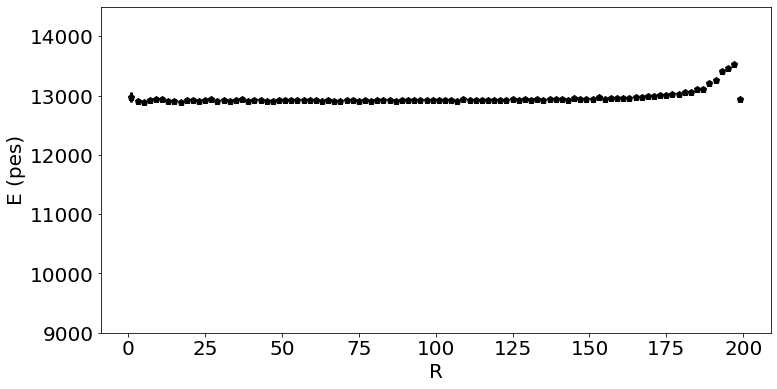

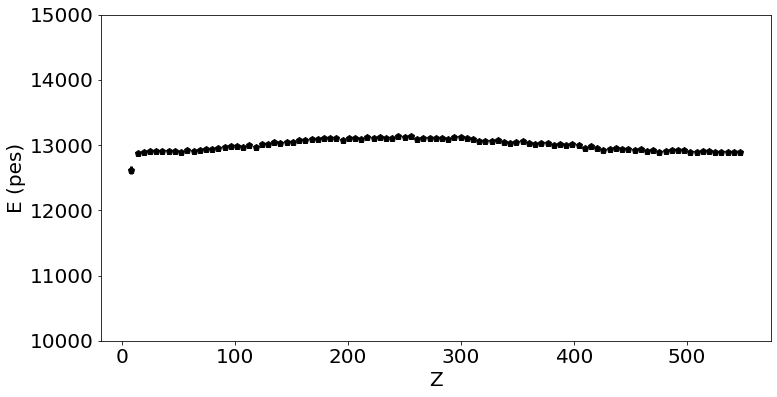

In [51]:
produce_and_check_map(sel_dst_zs1, sel_dst_zs1, 'selfcorrected')

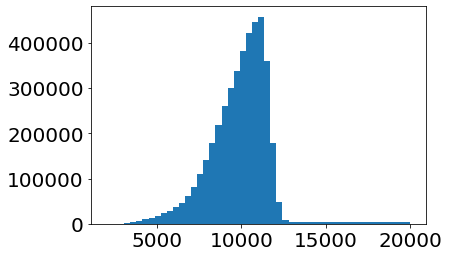

In [52]:
plt.hist(sel_dst_zs1.S2e, range = (2000, 20000), bins = 50)
plt.show()

## Alternate version with mask band

In [53]:
def band_cut_bootstrap(sel_dst, tag):

    self_bootstrap_file = os.path.join(output_maps_file, 'TEST_kr_emap_xy_r_'+str(run_number)+'_'+analysis_tag+'_'+tag+'.h5')
    
    self_boostrapmap = read_maps(self_bootstrap_file)
    
    bootstrapmap = self_boostrapmap
    
    geom_corr = e0_xy_correction(bootstrapmap)
    corr = geom_corr(sel_dst.X, sel_dst.Y)
    
    fig = plt.figure(figsize=(14,8))
    plt.subplot(3, 1, 1)
    plt.hist2d(sel_dst.Z, sel_dst.S2e, 50, range=[[0,510],[5000, 16000]]);

    plt.title('S2e uncorrected')
    plt.subplot(3, 1, 2)
    plt.hist2d(sel_dst.Z, sel_dst.S2e*corr, 50, range=[[0,510],[11000, 14000]])
    plt.title('S2e corrected boot map')

    plt.subplot(3, 1, 3)
    plt.hist2d(sel_dst.Z, sel_dst.S2e*corr, 50, range=[[0,510],[11000, 14000]])
    plt.title('S2e corrected boot map zoom')
    plt.tight_layout()
    
    config['band_sel_params']
    
    band_sel_params_new = config['band_sel_params']
    band_sel_params_new['range_Z'] = (5, 510)
    band_sel_params_new['range_E'] = (11000, 14000)
    #band_sel_params_new['range_Z'] = (10, 510)
    band_sel_params_new['nsigma_sel'] = 3.5
    #config.update(dict(map_params = map_params_new))
    band_sel_params_new

    band_sel_params = config_values.band_sel_params
    nomask = np.ones(len(sel_dst.S2e), dtype='bool')
    mask_band = band_selector_and_check(dst        = sel_dst         ,
                                        boot_map   = bootstrapmap,
                                        input_mask = nomask     ,
                                        **band_sel_params_new    )
    eff = sel_dst.event.nunique()/sel_dst.event.nunique()
    print('Band selection efficiency: ', eff*100, '%')

    emaps = e0_xy_correction(bootstrapmap)
    E0 = sel_dst.S2e.values * emaps(sel_dst.X.values, sel_dst.Y.values)

    sel_krband = np.zeros_like(nomask)
    sel_krband[nomask], fpl, fph, hp, pp = selection_in_band(sel_dst[nomask].Z,
                                                              E0,
                                                              range_z = band_sel_params_new['range_Z'],
                                                              range_e = band_sel_params_new['range_E'],
                                                              nbins_z = band_sel_params_new['nbins_z'],
                                                              nbins_e = band_sel_params_new['nbins_e'],
                                                              nsigma  = band_sel_params_new['nsigma_sel'])

    plot_selection_in_band(fpl, fph, hp, pp, nsigma = band_sel_params_new['nsigma_sel'])
    
    corr_band = geom_corr(sel_dst[mask_band].X, sel_dst[mask_band].Y)
    fig = plt.figure(figsize=(13,6))
    plt.subplot(1, 2, 1)
    plt.hist(sel_dst.S2e*corr,  bins = 50, range =(7000, 16000))
    plt.title('Pre-filter');
    plt.xlabel('E (pes)');
    plt.ylabel('Entries');
    plt.subplot(1, 2, 2)
    plt.hist(sel_dst[mask_band].S2e*corr_band,  bins = 50, range =(7000, 16000))
    plt.title('Post-filter');
    plt.xlabel('E (pes)');
    plt.ylabel('Entries');

    band_sel_dst = sel_dst[mask_band]
    
    return band_sel_dst

Band selection efficiency:  100.0 %


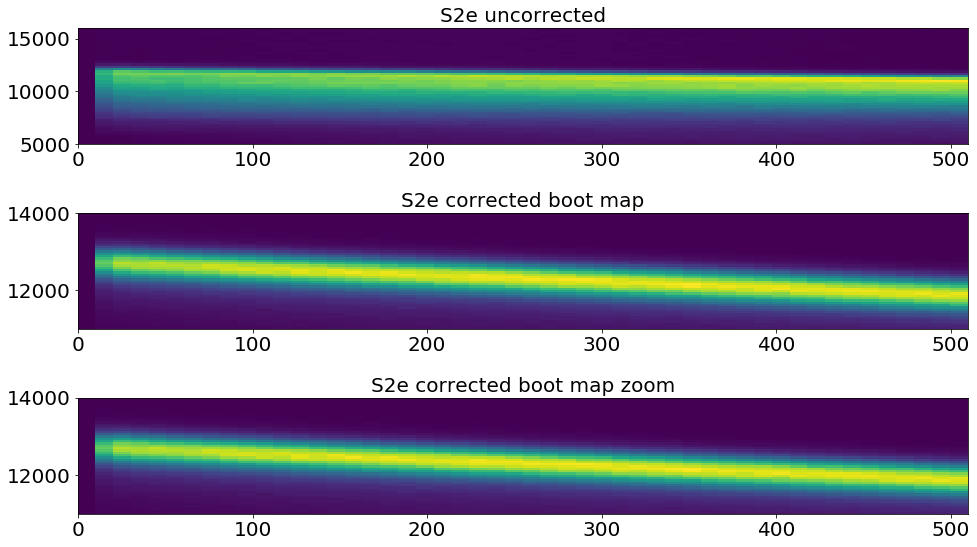

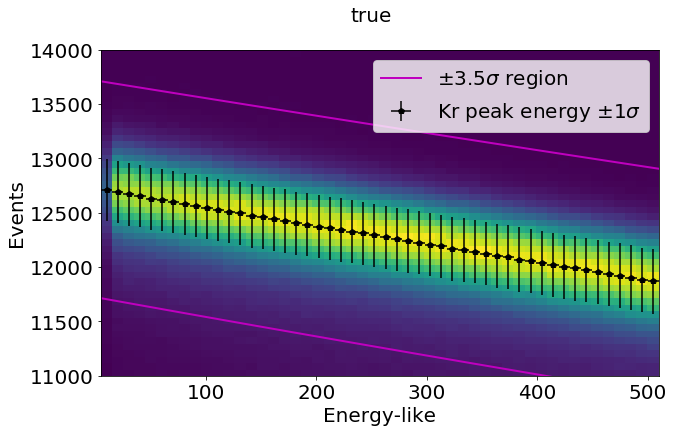

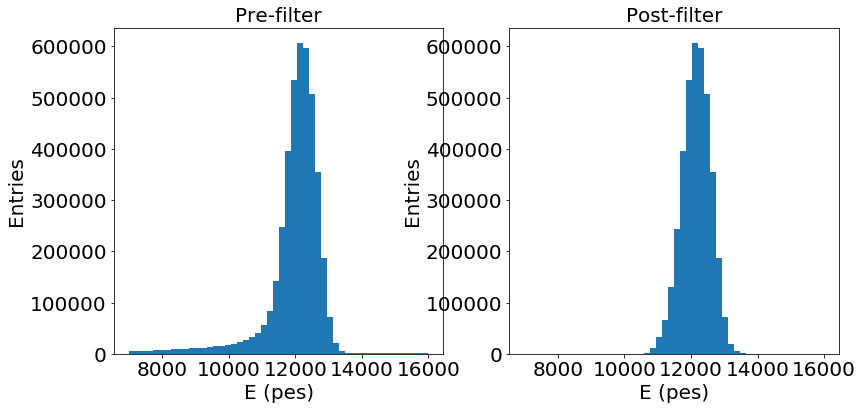

In [54]:
band_sel_dst_zs1 = band_cut_bootstrap(sel_dst_zs1, 'zs1')

Band selection efficiency:  100.0 %


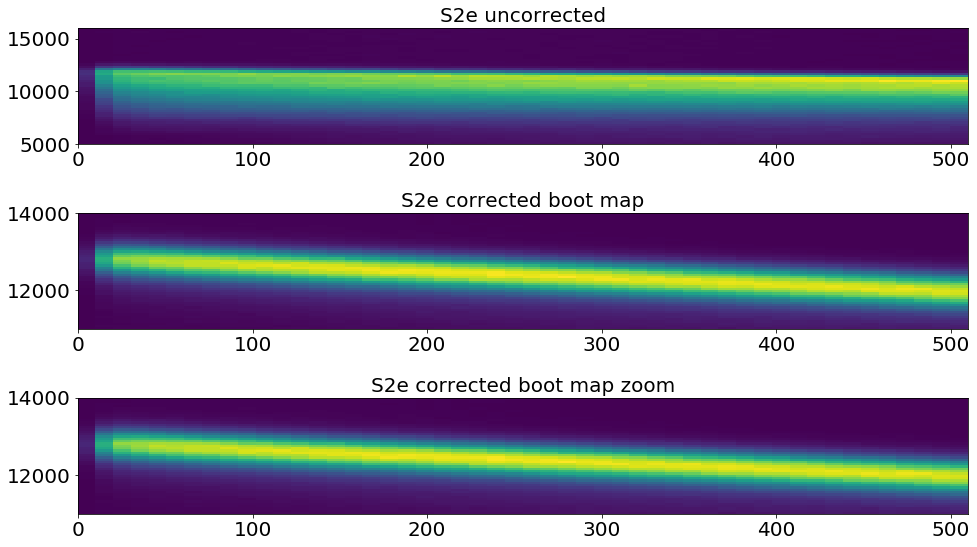

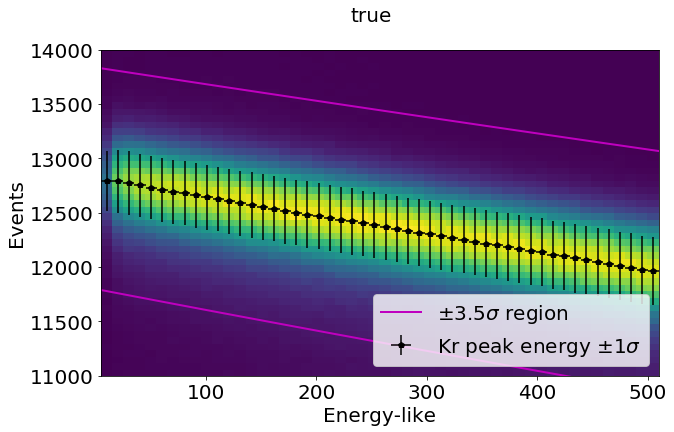

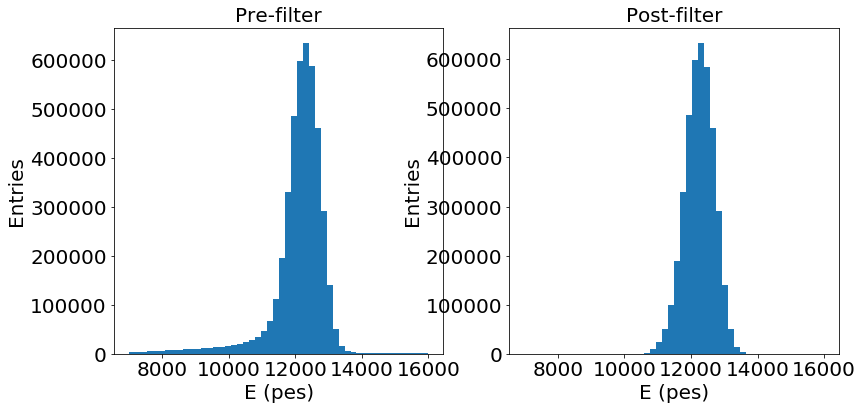

In [55]:
band_sel_dst_zrms = band_cut_bootstrap(sel_dst_zrms, 'zrms')

In [56]:
band_zrms_mapset = (band_sel_dst_zrms.event % 2 == 0)
band_zrms_resset = (band_sel_dst_zrms.event % 2 == 1)

band_zs1_mapset = (band_sel_dst_zs1.event % 2 == 0)
band_zs1_resset = (band_sel_dst_zs1.event % 2 == 1)

Number of XY bins:  100 ( 1883055 events)
Calculating map...
Calculated map. Proceeding to check fits.
    Number of failing fits: 672
Showing determined maps


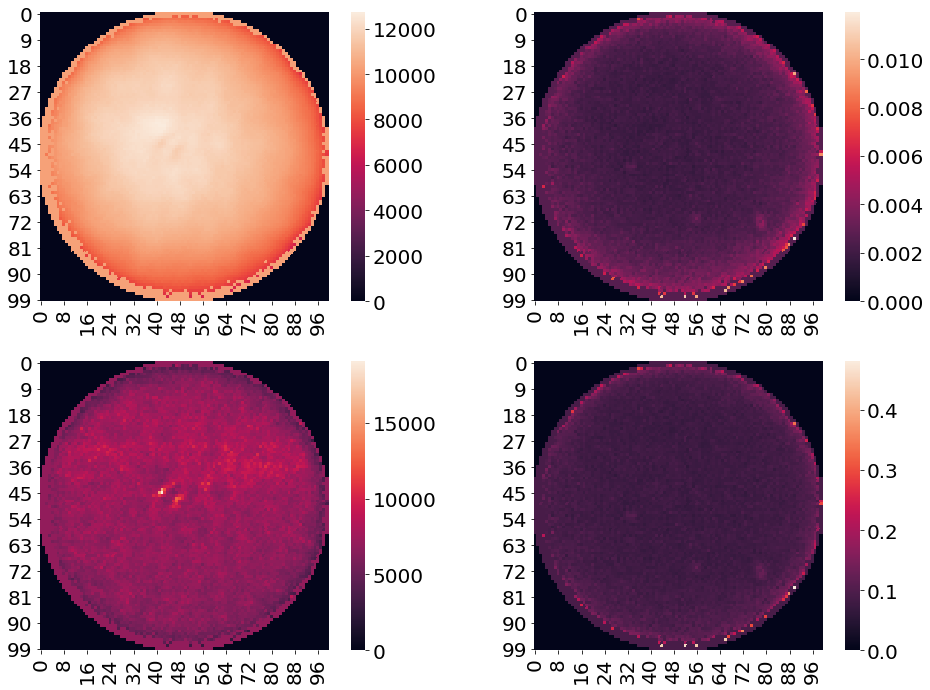

xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7472
dtype: int64
Try to open and show map...
xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7472
dtype: int64
Show corrected energy vs Z...


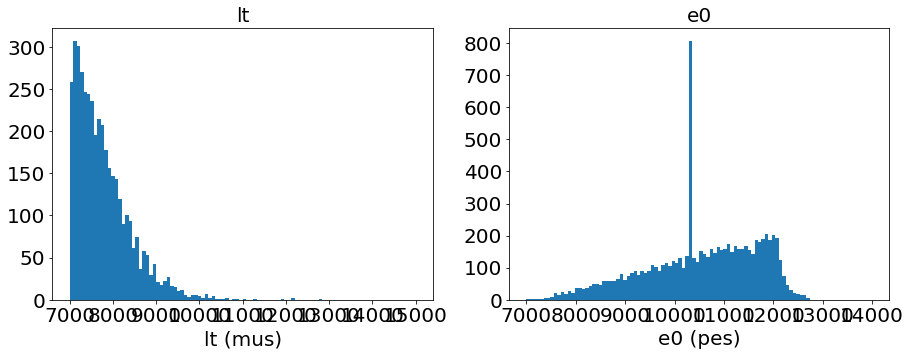

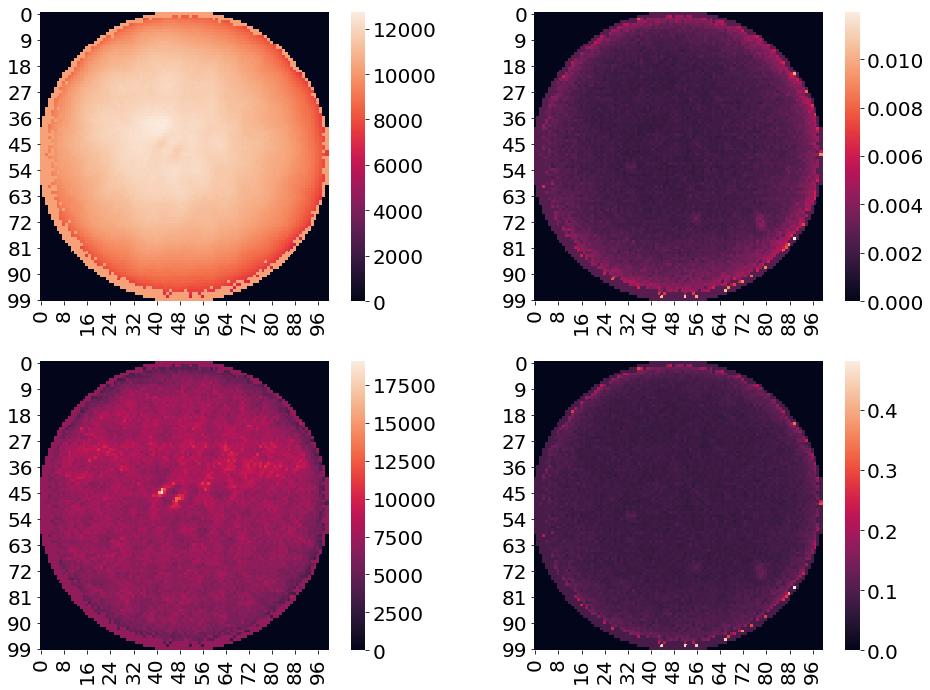

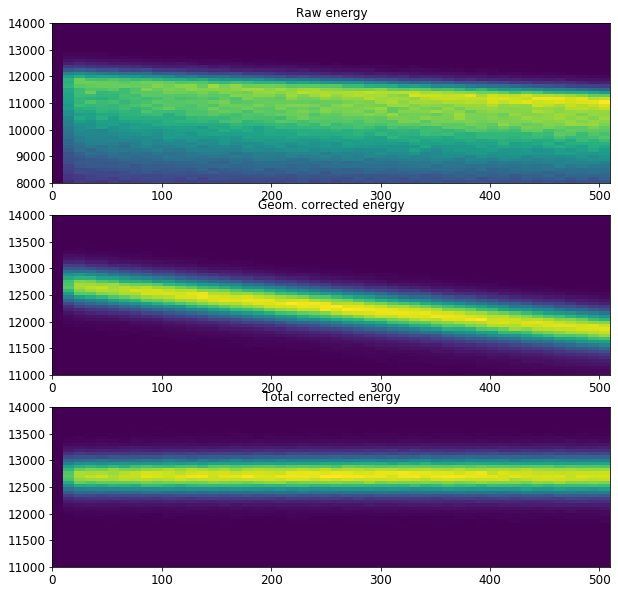

Show corrected Kr peak...
  Fit was valid = True
 Emu       = 12720.521423612934 +-0.17508135842256295 
 E sigma   = 235.2329494046693 +-0.13322143079231702 
 chi2    = 43.59464484494056 
 sigma E/E (FWHM)     (%) =4.345713612610426
 sigma E/E (FWHM) Qbb (%) =0.5612574147797172 
Resolution vs ZR...


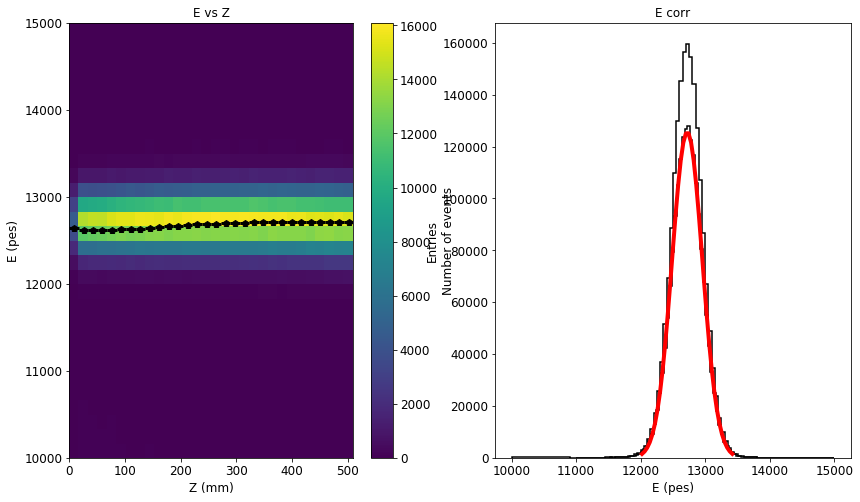

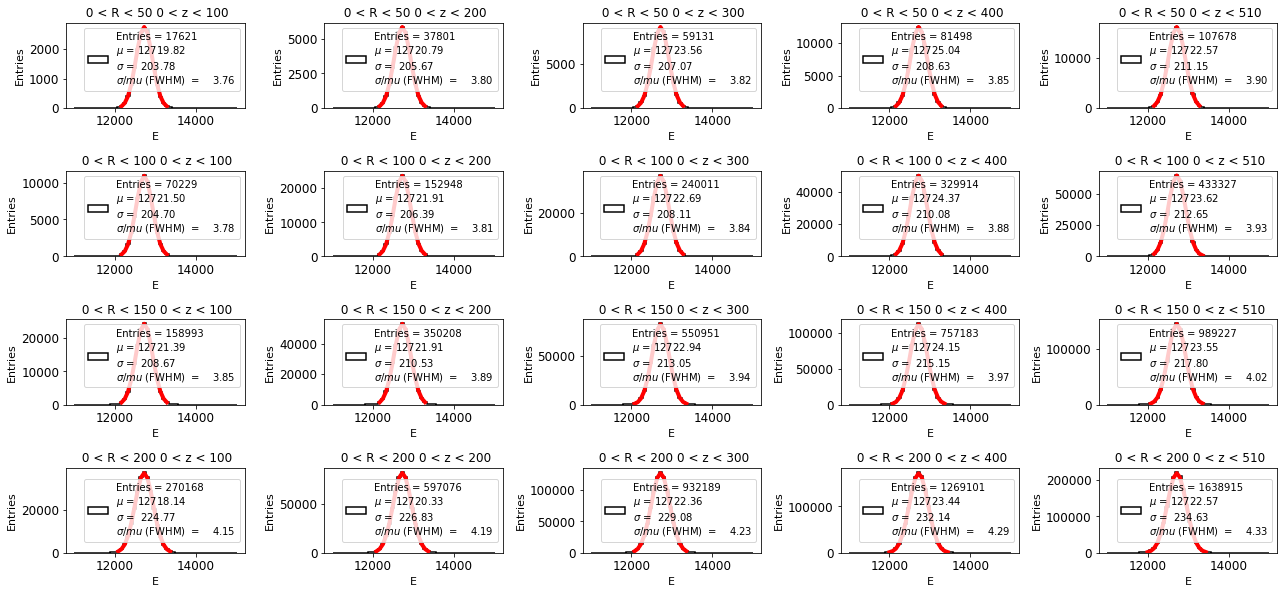

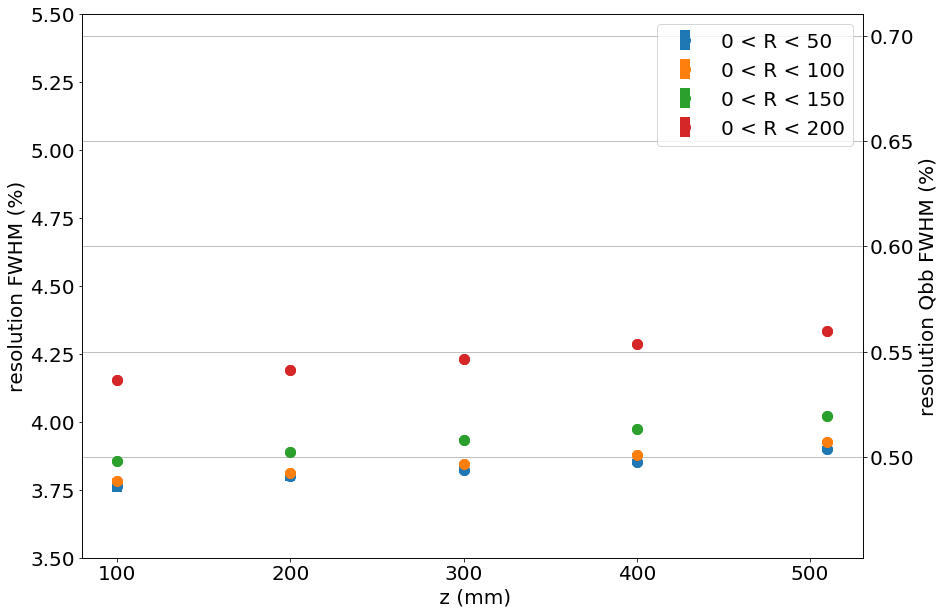

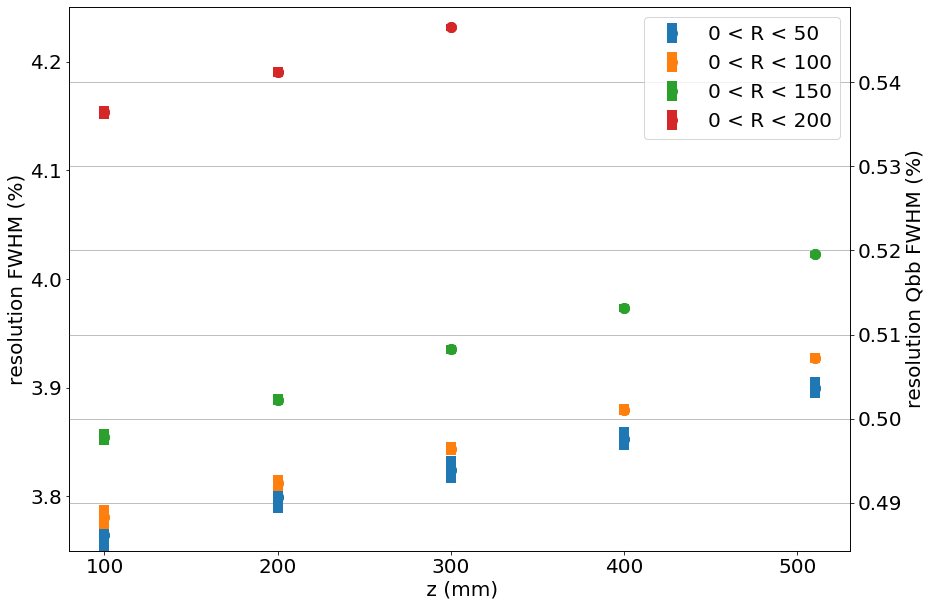

Additional plots


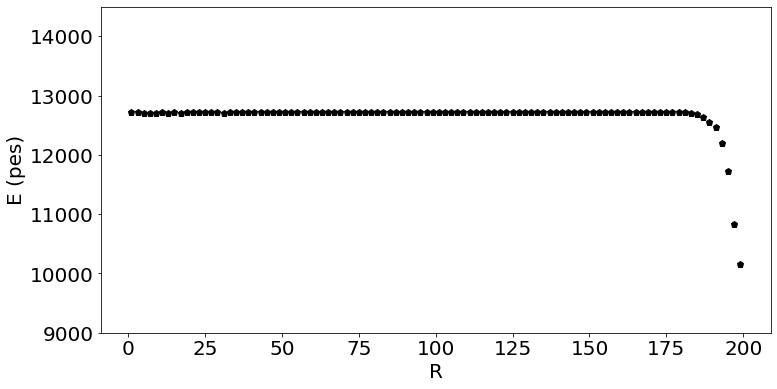

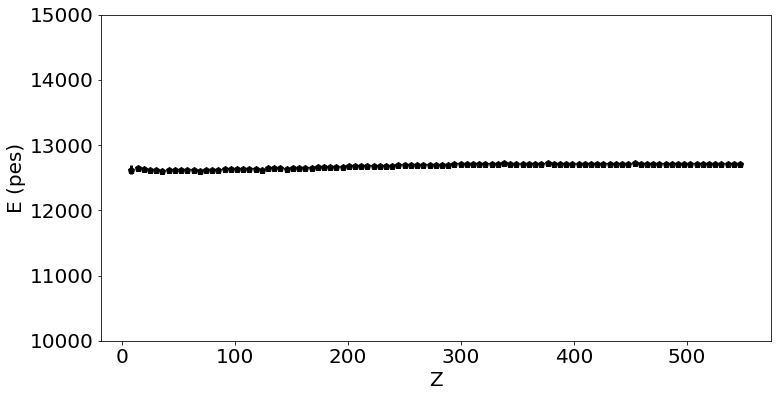

In [57]:
produce_and_check_map(band_sel_dst_zs1[band_zs1_mapset], band_sel_dst_zs1[band_zs1_resset], 'band_zs1')

Number of XY bins:  100 ( 1984528 events)
Calculating map...
Calculated map. Proceeding to check fits.
    Number of failing fits: 553
Showing determined maps


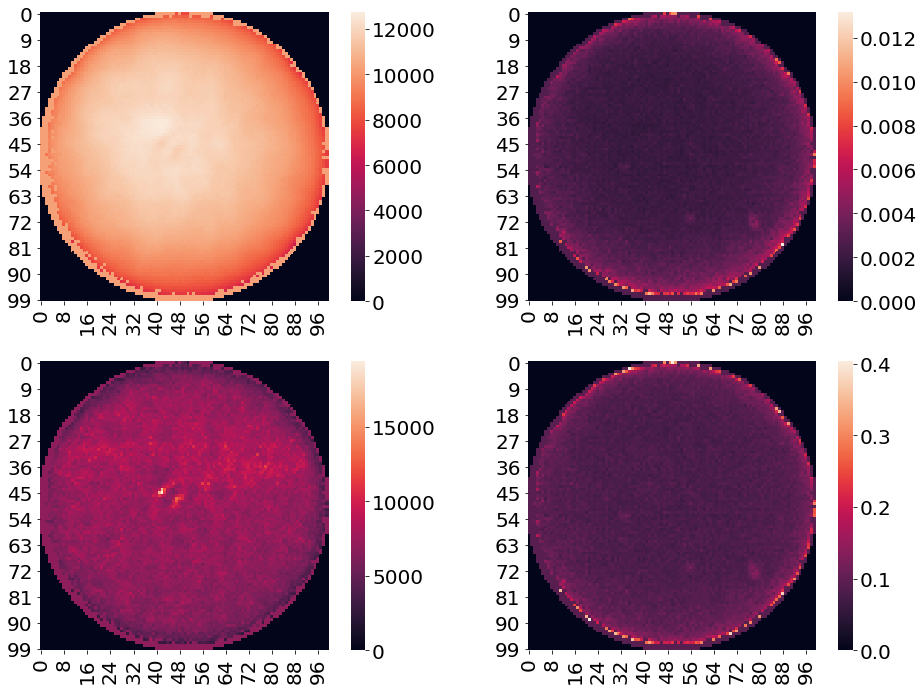

xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7472
dtype: int64
Try to open and show map...
xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    7472
dtype: int64
Show corrected energy vs Z...


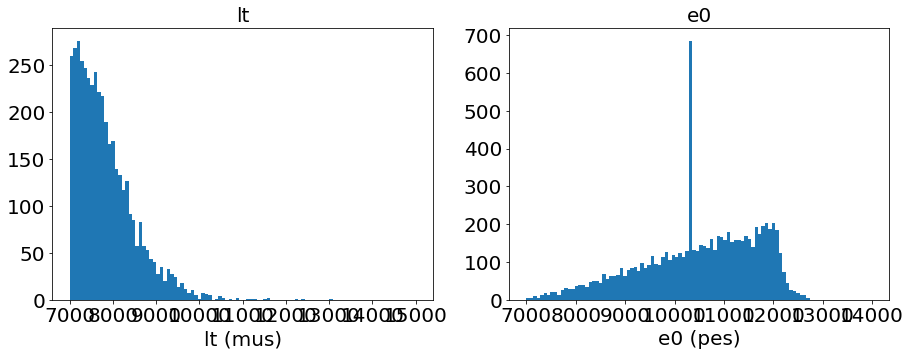

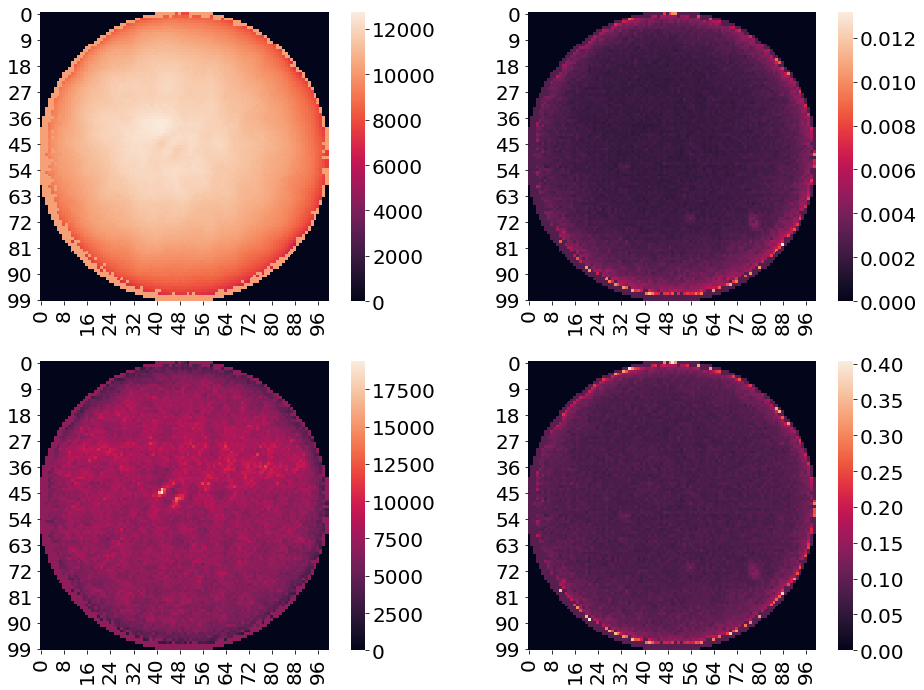

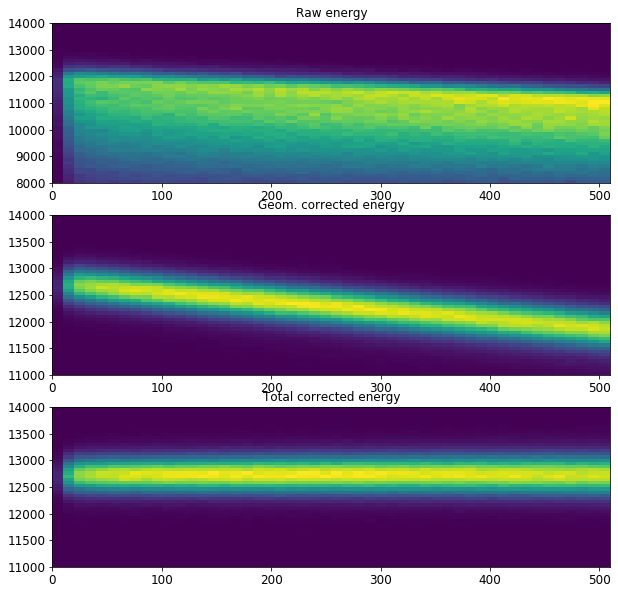

Show corrected Kr peak...
  Fit was valid = True
 Emu       = 12739.389881311348 +-0.1782272303992956 
 E sigma   = 246.22492219122591 +-0.13620535437004608 
 chi2    = 109.89194889560609 
 sigma E/E (FWHM)     (%) =4.542043006299913
 sigma E/E (FWHM) Qbb (%) =0.5866137400625607 
Resolution vs ZR...


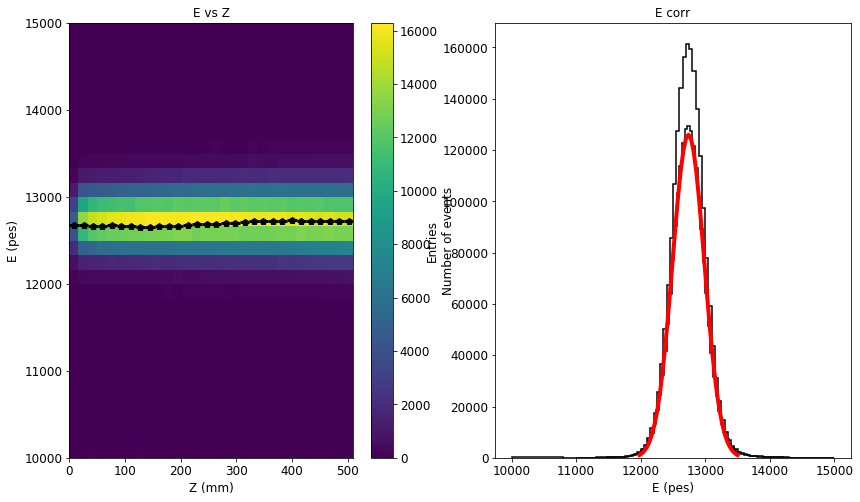

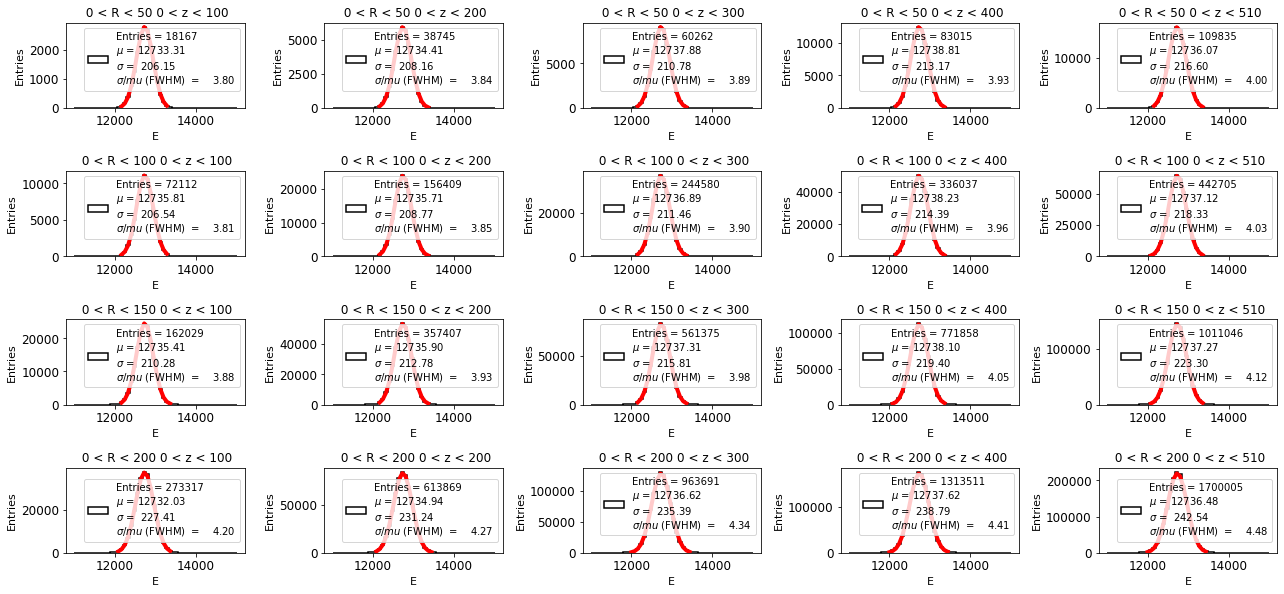

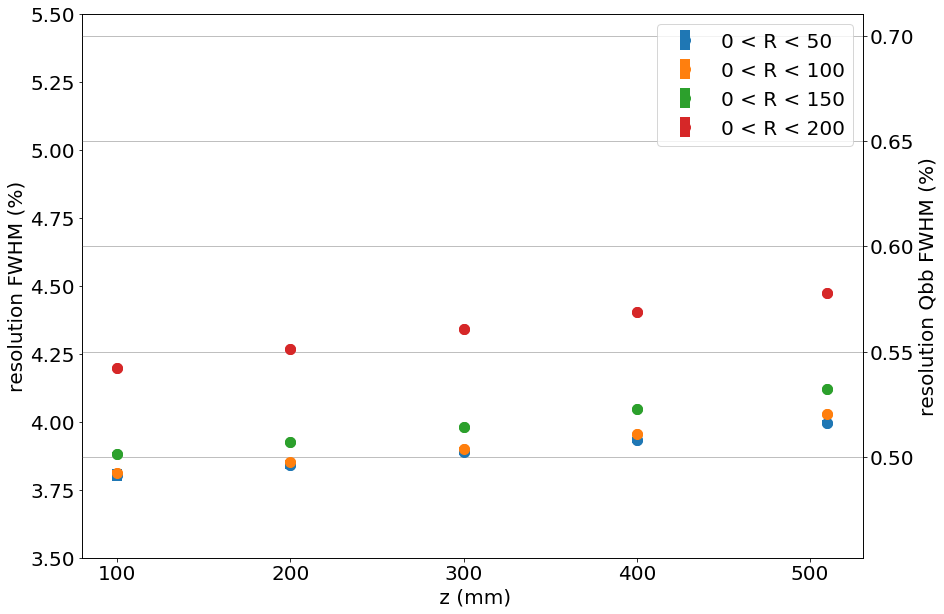

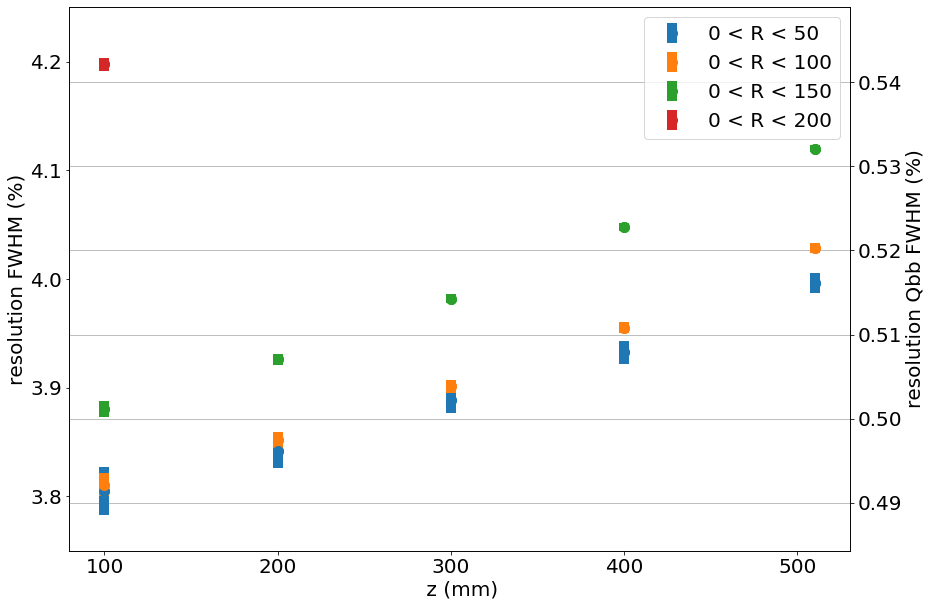

Additional plots


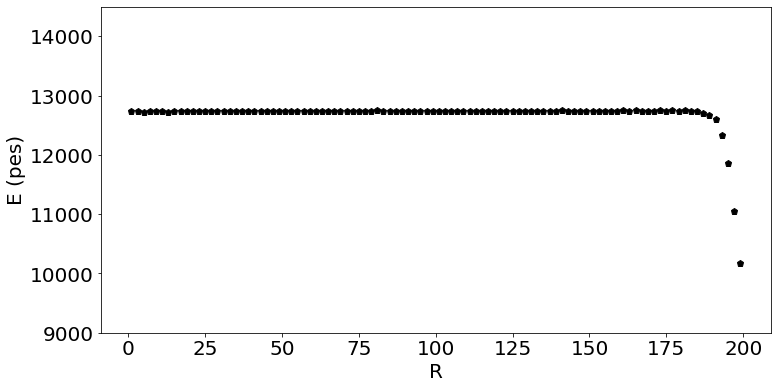

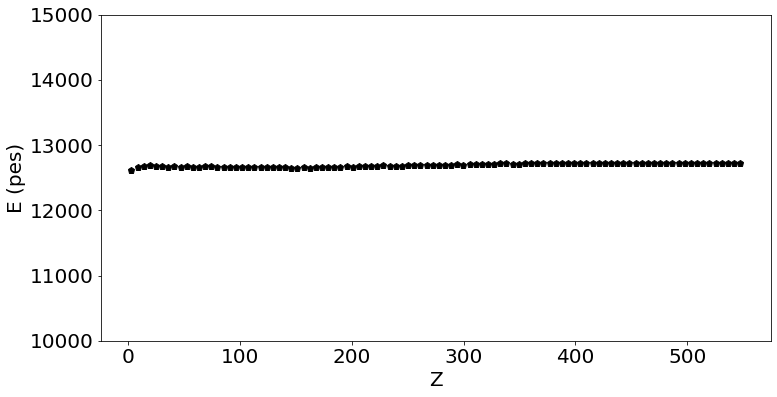

In [58]:
produce_and_check_map(band_sel_dst_zrms[band_zrms_mapset], band_sel_dst_zrms[band_zrms_resset], 'band_zrms')